# Setup

In [ ]:
# export LD_LIBRARY_PATH=/home/alinezhad.f/miniconda3/envs/farbod_new/lib:$LD_LIBRARY_PATH

In [1]:
getwd()

[1] "/Users/alinezhad.f/Documents/clustering_physicians"

In [2]:
library(keras)
library(tensorflow)
tf$test$gpu_device_name()

Loaded Tensorflow version 2.10.0



[1] "/device:GPU:0"

In [3]:
options(repr.matrix.max.rows=100, repr.matrix.max.cols=300)
options(
    repr.plot.res = 120,
    repr.plot.width = 10,
    repr.plot.height = 7, 
    repr.plot.pointsize = 12, 
    repr.plot.quality = 100
)
options(width=300)
    
numcores = 30

library(tidyverse)
library(parallel)
library(data.table)
library(fst)
library(comorbidity)
library(zeallot)
library(dtplyr)
library(vroom)
library(dplyr)
library(FactoMineR)
library(factoextra)
library(plyr)

#library(icd)
`%!in%` = Negate(`%in%`)

setDTthreads(numcores)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’

# Extracting the needed data from the datasets
Here, we will create a data.table with the following columns:
* id: the unique identifier of each Medicare beneficiary
* year: the year of the Medicare claim
* diagnosis: the diagnosis code of the claim
* procedure: the procedure code of the claim
* provider: the provider of the claim
* provider_specialty: the specialty of the provider
* cost: the cost of the claim

We will only use 2016 to 2019 data for this analysis.
We exclude 2020 due to the COVID-19 pandemic. We exclude 2013-2015 due to use of the ICD-9 coding system.

## Carrier files

In [13]:
carrier_data_2016 = read_fst("/work/postresearch/Shared/Projects/Data_fst/carrier_data_2016.fst",
    as.data.table = T,
    columns = c("DESY_SORT_KEY", "LINE_ICD_DGNS_CD", "PRF_PHYSN_NPI", "PRVDR_SPCLTY", "HCPCS_CD", "CLM_THRU_DT", "LINE_ALOWD_CHRG_AMT")
)
carrier_data_2017 = read_fst("/work/postresearch/Shared/Projects/Data_fst/carrier_data_2017.fst",
    as.data.table = T,
    columns = c("DESY_SORT_KEY", "LINE_ICD_DGNS_CD", "PRF_PHYSN_NPI", "PRVDR_SPCLTY", "HCPCS_CD", "CLM_THRU_DT", "LINE_ALOWD_CHRG_AMT")
)
carrier_data_2018 = read_fst("/work/postresearch/Shared/Projects/Data_fst/carrier_data_2018.fst",
    as.data.table = T,
    columns = c("DESY_SORT_KEY", "LINE_ICD_DGNS_CD", "PRF_PHYSN_NPI", "PRVDR_SPCLTY", "HCPCS_CD", "CLM_THRU_DT", "LINE_ALOWD_CHRG_AMT")
)
carrier_data_2019 = read_fst("/work/postresearch/Shared/Projects/Data_fst/carrier_data_2019.fst",
    as.data.table = T,
    columns = c("DESY_SORT_KEY", "LINE_ICD_DGNS_CD", "PRF_PHYSN_NPI", "PRVDR_SPCLTY", "HCPCS_CD", "CLM_THRU_DT", "LINE_ALOWD_CHRG_AMT")
)

In [ ]:
# change the column names
setnames(
    carrier_data_2016,
    c("id", "diagnosis", "provider", "provider_specialty", "hcpcs", "date", "cost")
)

setnames(
    carrier_data_2017,
    c("id", "diagnosis", "provider", "provider_specialty", "hcpcs", "date", "cost")
)

setnames(
    carrier_data_2018,
    c("id", "diagnosis", "provider", "provider_specialty", "hcpcs", "date", "cost")
)

setnames(
    carrier_data_2019,
    c("id", "diagnosis", "provider", "provider_specialty", "hcpcs", "date", "cost")
)

In [ ]:
# add the year to the data
carrier_data_2016[, year := 2016]
carrier_data_2017[, year := 2017]
carrier_data_2018[, year := 2018]
carrier_data_2019[, year := 2019]

# combine the data

carrier_data = rbindlist(
    list(
        carrier_data_2016,
        carrier_data_2017,
        carrier_data_2018,
        carrier_data_2019
    ),
    use.names = T
)

In [ ]:
head(carrier_data)

id,diagnosis,provider,provider_specialty,hcpcs,date,cost,year
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
100000015,H3532,1265609275,18,67028,20160129,110.66,2016
100000015,H3532,1265609275,18,J0178,20160129,1961.00,2016
100000015,I10,1730170630,06,99214,20160212,113.64,2016
100000015,I10,1730170630,06,93000,20160212,18.34,2016
100000015,I479,1730170630,06,93457,20160218,371.86,2016
100000015,I252,1730170630,06,99217,20160219,75.37,2016


In [ ]:
# Save the combined data as fst to folder with no compression
write_fst(carrier_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/carrier_data.fst", compress = 0)

## Inpatient files

In [ ]:
inpatient_data_2016 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2016.fst", as.data.table = T)
inpatient_data_2017 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2017.fst",as.data.table = T)
inpatient_data_2018 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2018.fst", as.data.table = T)
inpatient_data_2019 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2019.fst",as.data.table = T)

In [ ]:
# add the year to the data

inpatient_data_2016[, year := 2016]
inpatient_data_2017[, year := 2017]
inpatient_data_2018[, year := 2018]
inpatient_data_2019[, year := 2019]


#combine the data
inpatient_data = rbindlist(
    list(
        inpatient_data_2016,
        inpatient_data_2017,
        inpatient_data_2018,
        inpatient_data_2019
    ),
    use.names = T
)


In [ ]:
# Save the combined data as fst to folder with no compression
write_fst(inpatient_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/inpatient_data.fst", compress = 0)

## Outpatient files

In [ ]:
outpatient_data_2016 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2016.fst",as.data.table = T)
outpatient_data_2017 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2017.fst",as.data.table = T)
outpatient_data_2018 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2018.fst",as.data.table = T)
outpatient_data_2019 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2019.fst",as.data.table = T)

In [ ]:
# add the year to the data

outpatient_data_2016[, year := 2016]
outpatient_data_2017[, year := 2017]
outpatient_data_2018[, year := 2018]
outpatient_data_2019[, year := 2019]


# combine the data
outpatient_data = rbindlist(
    list(
        outpatient_data_2016,
        outpatient_data_2017,
        outpatient_data_2018,
        outpatient_data_2019
    ),
    use.names = T
)

In [ ]:
# Save the combined data as fst to folder with no compression
write_fst(outpatient_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/outpatient_data.fst", compress = 0)

## Create a small sample for local analyses

In [ ]:
# create a sample of 10000 patients based on id
sample_id = sample(carrier_data$id, 10000)

# sample the data based on the ids sampled
carrier_data_sample = carrier_data[id %in% sample_id]
inpatient_data_sample = inpatient_data[DESY_SORT_KEY %in% sample_id]
outpatient_data_sample = outpatient_data[DESY_SORT_KEY %in% sample_id]


In [ ]:
head(carrier_data_sample)
head(inpatient_data_sample)
head(outpatient_data_sample)


id,diagnosis,provider,provider_specialty,hcpcs,date,cost,year
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
100009375,H2703,1245214063,18,92014,20160118,117.32,2016
100009375,K635,1215931563,10,99215,20160307,138.05,2016
100009375,K635,1215931563,10,1036F,20160307,0.00,2016
100009375,K635,1215931563,10,G8420,20160307,0.00,2016
100009375,K635,1215931563,10,G8752,20160307,0.00,2016
100009375,K635,1215931563,10,G8754,20160307,0.00,2016


DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,FI_CLM_ACTN_CD,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_PPS_IND_CD,CLM_TOT_CHRG_AMT,CLM_ADMSN_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,NCH_IP_NCVRD_CHRG_AMT,CLM_TOT_PPS_CPTL_AMT,CLM_PPS_CPTL_FSP_AMT,CLM_PPS_CPTL_OUTLIER_AMT,CLM_PPS_CPTL_DSPRPRTNT_SHR_AMT,CLM_PPS_CPTL_IME_AMT,CLM_PPS_CPTL_EXCPTN_AMT,CLM_PPS_OLD_CPTL_HLD_HRMLS_AMT,CLM_PPS_CPTL_DRG_WT_NUM,CLM_UTLZTN_DAY_CNT,BENE_TOT_COINSRNC_DAYS_CNT,BENE_LRD_USED_CNT,CLM_NON_UTLZTN_DAYS_CNT,NCH_BLOOD_PNTS_FRNSHD_QTY,NCH_VRFD_NCVRD_STAY_FROM_DT,NCH_VRFD_NCVRD_STAY_THRU_DT,NCH_BENE_MDCR_BNFTS_EXHTD_DT_I,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,CLM_DRG_OUTLIER_STAY_CD,NCH_DRG_OUTLIER_APRVD_PMT_AMT,ADMTG_DGNS_CD,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,CLM_POA_IND_SW1,ICD_DGNS_CD2,CLM_POA_IND_SW2,ICD_DGNS_CD3,CLM_POA_IND_SW3,ICD_DGNS_CD4,CLM_POA_IND_SW4,ICD_DGNS_CD5,CLM_POA_IND_SW5,ICD_DGNS_CD6,CLM_POA_IND_SW6,ICD_DGNS_CD7,CLM_POA_IND_SW7,ICD_DGNS_CD8,CLM_POA_IND_SW8,ICD_DGNS_CD9,CLM_POA_IND_SW9,ICD_DGNS_CD10,CLM_POA_IND_SW10,ICD_DGNS_CD11,CLM_POA_IND_SW11,ICD_DGNS_CD12,CLM_POA_IND_SW12,ICD_DGNS_CD13,CLM_POA_IND_SW13,ICD_DGNS_CD14,CLM_POA_IND_SW14,ICD_DGNS_CD15,CLM_POA_IND_SW15,ICD_DGNS_CD16,CLM_POA_IND_SW16,ICD_DGNS_CD17,CLM_POA_IND_SW17,ICD_DGNS_CD18,CLM_POA_IND_SW18,ICD_DGNS_CD19,CLM_POA_IND_SW19,ICD_DGNS_CD20,CLM_POA_IND_SW20,ICD_DGNS_CD21,CLM_POA_IND_SW21,ICD_DGNS_CD22,CLM_POA_IND_SW22,ICD_DGNS_CD23,CLM_POA_IND_SW23,ICD_DGNS_CD24,CLM_POA_IND_SW24,ICD_DGNS_CD25,CLM_POA_IND_SW25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,CLM_E_POA_IND_SW1,ICD_DGNS_E_CD2,CLM_E_POA_IND_SW2,ICD_DGNS_E_CD3,CLM_E_POA_IND_SW3,ICD_DGNS_E_CD4,CLM_E_POA_IND_SW4,ICD_DGNS_E_CD5,CLM_E_POA_IND_SW5,ICD_DGNS_E_CD6,CLM_E_POA_IND_SW6,ICD_DGNS_E_CD7,CLM_E_POA_IND_SW7,ICD_DGNS_E_CD8,CLM_E_POA_IND_SW8,ICD_DGNS_E_CD9,CLM_E_POA_IND_SW9,ICD_DGNS_E_CD10,CLM_E_POA_IND_SW10,ICD_DGNS_E_CD11,CLM_E_POA_IND_SW11,ICD_DGNS_E_CD12,CLM_E_POA_IND_SW12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_IP_LOW_VOL_PMT_AMT,CLM_CARE_IMPRVMT_MODEL_CD1,CLM_CARE_IMPRVMT_MODEL_CD2,CLM_CARE_IMPRVMT_MODEL_CD3,CLM_CARE_IMPRVMT_MODEL_CD4,CLM_BNDLD_MODEL_1_DSCNT_PCT,CLM_BASE_OPRTG_DRG_AMT,CLM_VBP_PRTCPNT_IND_CD,CLM_VBP_ADJSTMT_PCT,CLM_HRR_PRTCPNT_IND_CD,CLM_HRR_ADJSTMT_PCT,CLM_MODEL_4_READMSN_IND_CD,CLM_UNCOMPD_CARE_PMT_AMT,CLM_BNDLD_ADJSTMT_PMT_AMT,CLM_VBP_ADJSTMT_PMT_AMT,CLM_HRR_ADJSTMT_PMT_AMT,EHR_PYMT_ADJSTMT_AMT,PPS_STD_VAL_PYMT_AMT,FINL_STD_AMT,HAC_PGM_RDCTN_IND_SW,EHR_PGM_RDCTN_IND_SW,CLM_SITE_NTRL_PYMT_CST_AMT,CLM_SITE_NTRL_PYMT_IPPS_AMT,CLM_FULL_STD_PYMT_AMT,CLM_SS_OUTLIER_STD_PYMT_AMT,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int

DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,PRVDR_STATE_CD,ORG_NPI_NUM,SRVC_LOC_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,RFR_PHYSN_NPI,RFR_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_TOT_CHRG_AMT,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,ICD_DGNS_CD7,ICD_DGNS_CD8,ICD_DGNS_CD9,ICD_DGNS_CD10,ICD_DGNS_CD11,ICD_DGNS_CD12,ICD_DGNS_CD13,ICD_DGNS_CD14,ICD_DGNS_CD15,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,ICD_DGNS_E_CD2,ICD_DGNS_E_CD3,ICD_DGNS_E_CD4,ICD_DGNS_E_CD5,ICD_DGNS_E_CD6,ICD_DGNS_E_CD7,ICD_DGNS_E_CD8,ICD_DGNS_E_CD9,ICD_DGNS_E_CD10,ICD_DGNS_E_CD11,ICD_DGNS_E_CD12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,RSN_VISIT_CD1,RSN_VISIT_CD2,RSN_VISIT_CD3,NCH_BENE_PTB_DDCTBL_AMT,NCH_BENE_PTB_COINSRNC_AMT,CLM_OP_PRVDR_PMT_AMT,CLM_OP_BENE_PMT_AMT,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,FI_CLM_ACTN_CD,NCH_BLOOD_PNTS_FRNSHD_QTY,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_OP_TRANS_TYPE_CD,CLM_OP_ESRD_MTHD_CD,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<int>,<chr>,<int>,<chr>,<lgl>,<int>,<chr>,<lgl>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<lgl>,<lgl>,<lgl>,<chr>,<dbl>
100009375,934,330222,20160311,W,40,3,1,4,1,13201,,33.22,0,,33,1073569331,NA,,1215931563,10,NA,NA,,NA,NA,,NA,,NA,,NA,1,678,0,NA,Z1211,Z1211,Z86010,K648,K635,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,Z1211,Z86010,K648,0.00,8.48,33.22,0,4,1,1,640,33,10,1,0,,1,J,0,NA,NA,NA,NA,NA,,2016
100009375,935,330222,20160620,W,40,5,1,3,I,13201,,27.50,0,,33,1073569331,NA,,1154300762,92,NA,NA,,NA,NA,,NA,,NA,,NA,1,277,0,NA,C61,C61,,,,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,C61,,,0.00,0.00,27.50,0,5,1,1,640,33,10,5,0,,1,C,0,NA,NA,NA,NA,NA,,2016
100009375,936,330222,20160624,W,40,3,1,3,1,13201,,71.05,

In [ ]:
length(unique(carrier_data_sample$id))
length(unique(inpatient_data_sample$DESY_SORT_KEY))
length(unique(outpatient_data_sample$DESY_SORT_KEY))

[1] 9957

[1] 5807

[1] 9448

In [ ]:
# save the sample to fst
write_fst(carrier_data_sample, "/work/postresearch/Shared/Projects/Farbod/Clustering/carrier_data_sample.fst")
write_fst(inpatient_data_sample, "/work/postresearch/Shared/Projects/Farbod/Clustering/inpatient_data_sample.fst")
write_fst(outpatient_data_sample, "/work/postresearch/Shared/Projects/Farbod/Clustering/outpatient_data_sample.fst")

## Extract the diagnoses and procedures from the files

We will also turn all the data into wide format.

In [ ]:
# read the data
carrier_data <- read_fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/carrier_data.fst",
    as.data.table = TRUE
)
inpatient_data <- read_fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/inpatient_data.fst",
    as.data.table = TRUE
)
outpatient_data <- read_fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/outpatient_data.fst",
    as.data.table = TRUE
)

In [ ]:
nrow(carrier_data[unique(id)])

[1] 2478281

In [ ]:
# subset the data for analysis
# we will only use 100000 patients from 2016 for the analyses
carrier_data <- carrier_data[year == 2016, ]
inpatient_data <- inpatient_data[year == 2016, ]
outpatient_data <- outpatient_data[year == 2016, ]

#sampel ids
#create a sample of 50000 patients based on id
#sample_id = sample(unique(carrier_data$id), 200000)
#
## sample the data based on the ids sampled
#carrier_data = carrier_data[id %in% sample_id]
#inpatient_data = inpatient_data[DESY_SORT_KEY %in% sample_id]
#outpatient_data = outpatient_data[DESY_SORT_KEY %in% sample_id]



In [ ]:
head(carrier_data)
head(inpatient_data)
head(outpatient_data)

id,diagnosis,provider,provider_specialty,hcpcs,date,cost,year
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
100000015,H3532,1265609275,18,67028,20160129,110.66,2016
100000015,H3532,1265609275,18,J0178,20160129,1961.00,2016
100000015,I10,1730170630,06,99214,20160212,113.64,2016
100000015,I10,1730170630,06,93000,20160212,18.34,2016
100000015,I479,1730170630,06,93457,20160218,371.86,2016
100000015,I252,1730170630,06,99217,20160219,75.37,2016


DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,FI_CLM_ACTN_CD,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_PPS_IND_CD,CLM_TOT_CHRG_AMT,CLM_ADMSN_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,NCH_IP_NCVRD_CHRG_AMT,CLM_TOT_PPS_CPTL_AMT,CLM_PPS_CPTL_FSP_AMT,CLM_PPS_CPTL_OUTLIER_AMT,CLM_PPS_CPTL_DSPRPRTNT_SHR_AMT,CLM_PPS_CPTL_IME_AMT,CLM_PPS_CPTL_EXCPTN_AMT,CLM_PPS_OLD_CPTL_HLD_HRMLS_AMT,CLM_PPS_CPTL_DRG_WT_NUM,CLM_UTLZTN_DAY_CNT,BENE_TOT_COINSRNC_DAYS_CNT,BENE_LRD_USED_CNT,CLM_NON_UTLZTN_DAYS_CNT,NCH_BLOOD_PNTS_FRNSHD_QTY,NCH_VRFD_NCVRD_STAY_FROM_DT,NCH_VRFD_NCVRD_STAY_THRU_DT,NCH_BENE_MDCR_BNFTS_EXHTD_DT_I,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,CLM_DRG_OUTLIER_STAY_CD,NCH_DRG_OUTLIER_APRVD_PMT_AMT,ADMTG_DGNS_CD,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,CLM_POA_IND_SW1,ICD_DGNS_CD2,CLM_POA_IND_SW2,ICD_DGNS_CD3,CLM_POA_IND_SW3,ICD_DGNS_CD4,CLM_POA_IND_SW4,ICD_DGNS_CD5,CLM_POA_IND_SW5,ICD_DGNS_CD6,CLM_POA_IND_SW6,ICD_DGNS_CD7,CLM_POA_IND_SW7,ICD_DGNS_CD8,CLM_POA_IND_SW8,ICD_DGNS_CD9,CLM_POA_IND_SW9,ICD_DGNS_CD10,CLM_POA_IND_SW10,ICD_DGNS_CD11,CLM_POA_IND_SW11,ICD_DGNS_CD12,CLM_POA_IND_SW12,ICD_DGNS_CD13,CLM_POA_IND_SW13,ICD_DGNS_CD14,CLM_POA_IND_SW14,ICD_DGNS_CD15,CLM_POA_IND_SW15,ICD_DGNS_CD16,CLM_POA_IND_SW16,ICD_DGNS_CD17,CLM_POA_IND_SW17,ICD_DGNS_CD18,CLM_POA_IND_SW18,ICD_DGNS_CD19,CLM_POA_IND_SW19,ICD_DGNS_CD20,CLM_POA_IND_SW20,ICD_DGNS_CD21,CLM_POA_IND_SW21,ICD_DGNS_CD22,CLM_POA_IND_SW22,ICD_DGNS_CD23,CLM_POA_IND_SW23,ICD_DGNS_CD24,CLM_POA_IND_SW24,ICD_DGNS_CD25,CLM_POA_IND_SW25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,CLM_E_POA_IND_SW1,ICD_DGNS_E_CD2,CLM_E_POA_IND_SW2,ICD_DGNS_E_CD3,CLM_E_POA_IND_SW3,ICD_DGNS_E_CD4,CLM_E_POA_IND_SW4,ICD_DGNS_E_CD5,CLM_E_POA_IND_SW5,ICD_DGNS_E_CD6,CLM_E_POA_IND_SW6,ICD_DGNS_E_CD7,CLM_E_POA_IND_SW7,ICD_DGNS_E_CD8,CLM_E_POA_IND_SW8,ICD_DGNS_E_CD9,CLM_E_POA_IND_SW9,ICD_DGNS_E_CD10,CLM_E_POA_IND_SW10,ICD_DGNS_E_CD11,CLM_E_POA_IND_SW11,ICD_DGNS_E_CD12,CLM_E_POA_IND_SW12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_IP_LOW_VOL_PMT_AMT,CLM_CARE_IMPRVMT_MODEL_CD1,CLM_CARE_IMPRVMT_MODEL_CD2,CLM_CARE_IMPRVMT_MODEL_CD3,CLM_CARE_IMPRVMT_MODEL_CD4,CLM_BNDLD_MODEL_1_DSCNT_PCT,CLM_BASE_OPRTG_DRG_AMT,CLM_VBP_PRTCPNT_IND_CD,CLM_VBP_ADJSTMT_PCT,CLM_HRR_PRTCPNT_IND_CD,CLM_HRR_ADJSTMT_PCT,CLM_MODEL_4_READMSN_IND_CD,CLM_UNCOMPD_CARE_PMT_AMT,CLM_BNDLD_ADJSTMT_PMT_AMT,CLM_VBP_ADJSTMT_PMT_AMT,CLM_HRR_ADJSTMT_PMT_AMT,EHR_PYMT_ADJSTMT_AMT,PPS_STD_VAL_PYMT_AMT,FINL_STD_AMT,HAC_PGM_RDCTN_IND_SW,EHR_PGM_RDCTN_IND_SW,CLM_SITE_NTRL_PYMT_CST_AMT,CLM_SITE_NTRL_PYMT_IPPS_AMT,CLM_FULL_STD_PYMT_AMT,CLM_SS_OUTLIER_STD_PYMT_AMT,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int

DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,PRVDR_STATE_CD,ORG_NPI_NUM,SRVC_LOC_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,RFR_PHYSN_NPI,RFR_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_TOT_CHRG_AMT,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,ICD_DGNS_CD7,ICD_DGNS_CD8,ICD_DGNS_CD9,ICD_DGNS_CD10,ICD_DGNS_CD11,ICD_DGNS_CD12,ICD_DGNS_CD13,ICD_DGNS_CD14,ICD_DGNS_CD15,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,ICD_DGNS_E_CD2,ICD_DGNS_E_CD3,ICD_DGNS_E_CD4,ICD_DGNS_E_CD5,ICD_DGNS_E_CD6,ICD_DGNS_E_CD7,ICD_DGNS_E_CD8,ICD_DGNS_E_CD9,ICD_DGNS_E_CD10,ICD_DGNS_E_CD11,ICD_DGNS_E_CD12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,RSN_VISIT_CD1,RSN_VISIT_CD2,RSN_VISIT_CD3,NCH_BENE_PTB_DDCTBL_AMT,NCH_BENE_PTB_COINSRNC_AMT,CLM_OP_PRVDR_PMT_AMT,CLM_OP_BENE_PMT_AMT,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,FI_CLM_ACTN_CD,NCH_BLOOD_PNTS_FRNSHD_QTY,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_OP_TRANS_TYPE_CD,CLM_OP_ESRD_MTHD_CD,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<int>,<chr>,<int>,<chr>,<lgl>,<int>,<chr>,<lgl>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<lgl>,<lgl>,<lgl>,<chr>,<dbl>
100000015,2,220071,20160119,W,40,3,1,3,1,14211,,104.26,0,,22,1023049236,NA,,1174560288,11,NA,NA,,NA,NA,,NA,,NA,,NA,1,846.02,0,NA,J449,J449,,,,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,,,0,26.6,104.26,0,4,1,1,160,22,10,1,0,,1,C,0,NA,NA,NA,NA,NA,,2016
100000015,3,220071,20160122,W,40,3,1,3,1,14211,,52.13,0,,22,1023049236,NA,,1174560288,11,NA,NA,,NA,NA,,NA,,NA,,NA,1,423.00,0,NA,J449,J449,,,,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,,,0,13.3,52.13,0,4,1,1,160,22,10,1,0,,1,C,0,NA,NA,NA,NA,NA,,2016
100000015,4,220071,20160126,W,40,3,1,3,1,14211,,52.13,0,,22,1023049236,NA,,1174560288,11,N

In [ ]:
nrow(carrier_data[unique(id)])

[1] 1811122

### Inpatient and outpatient files

In [ ]:
# we will only use diagnosis codes for this project
find_all_diagnosis <- function(data, chunks=5) {
    data <- data[, .(
        id = DESY_SORT_KEY,
        year = year,
        # diagnosis_prncpl = PRNCPAL_DGNS_CD,
        diagnosis1 = substr(ICD_DGNS_CD1,1,3),
        diagnosis2 = substr(ICD_DGNS_CD2,1,3),
        diagnosis3 = substr(ICD_DGNS_CD3,1,3),
        diagnosis4 = substr(ICD_DGNS_CD4,1,3),
        diagnosis5 = substr(ICD_DGNS_CD5,1,3),
        diagnosis6 = substr(ICD_DGNS_CD6,1,3),
        diagnosis7 = substr(ICD_DGNS_CD7,1,3),
        diagnosis8 = substr(ICD_DGNS_CD8,1,3),
        diagnosis9 = substr(ICD_DGNS_CD9,1,3),
        diagnosis10 = substr(ICD_DGNS_CD10,1,3),
        diagnosis11 = substr(ICD_DGNS_CD11,1,3),
        diagnosis12 = substr(ICD_DGNS_CD12,1,3),
        diagnosis13 = substr(ICD_DGNS_CD13,1,3),
        diagnosis14 = substr(ICD_DGNS_CD14,1,3),
        diagnosis15 = substr(ICD_DGNS_CD15,1,3),
        diagnosis16 = substr(ICD_DGNS_CD16,1,3),
        diagnosis17 = substr(ICD_DGNS_CD17,1,3),
        diagnosis18 = substr(ICD_DGNS_CD18,1,3),
        diagnosis19 = substr(ICD_DGNS_CD19,1,3),
        diagnosis20 = substr(ICD_DGNS_CD20,1,3),
        diagnosis21 = substr(ICD_DGNS_CD21,1,3),
        diagnosis22 = substr(ICD_DGNS_CD22,1,3),
        diagnosis23 = substr(ICD_DGNS_CD23,1,3),
        diagnosis24 = substr(ICD_DGNS_CD24,1,3),
        diagnosis25 = substr(ICD_DGNS_CD25,1,3)
        #icd_procedure1 = ICD_PRCDR_CD1,
        #icd_procedure2 = ICD_PRCDR_CD2,
        #icd_procedure3 = ICD_PRCDR_CD3,
        #icd_procedure4 = ICD_PRCDR_CD4,
        #icd_procedure5 = ICD_PRCDR_CD5,
        #icd_procedure6 = ICD_PRCDR_CD6,
        #icd_procedure7 = ICD_PRCDR_CD7,
        #icd_procedure8 = ICD_PRCDR_CD8,
        #icd_procedure9 = ICD_PRCDR_CD9,
        #icd_procedure10 = ICD_PRCDR_CD10,
        #icd_procedure11 = ICD_PRCDR_CD11,
        #icd_procedure12 = ICD_PRCDR_CD12,
        #icd_procedure13 = ICD_PRCDR_CD13,
        #icd_procedure14 = ICD_PRCDR_CD14,
        #icd_procedure15 = ICD_PRCDR_CD15,
        #icd_procedure16 = ICD_PRCDR_CD16,
        #icd_procedure17 = ICD_PRCDR_CD17,
        #icd_procedure18 = ICD_PRCDR_CD18,
        #icd_procedure19 = ICD_PRCDR_CD19,
        #icd_procedure20 = ICD_PRCDR_CD20,
        #icd_procedure21 = ICD_PRCDR_CD21,
        #icd_procedure22 = ICD_PRCDR_CD22,
        #icd_procedure23 = ICD_PRCDR_CD23,
        #icd_procedure24 = ICD_PRCDR_CD24,
        #icd_procedure25 = ICD_PRCDR_CD25
    )]
    # melt the data to include the procedure and diagnosis codes in one column
    data <- melt(data, id.vars = c("id", "year")) %>% as.data.table()

    # change the data to wide format dcast the data

    #data<- dcast(data, id + year ~ value,
    #  value.var = "value", fun.aggregate = length
    #)

    # the data will be more than the machine row limit so we will split the data based on id and then dcast then combine the data

    #split the data to chunks based on id
    data_split <- split(data, list(data$id %% chunks))

    # dcast the data
    data_split <- lapply(
        data_split,
        function(x) {
            x <- dcast(x, id + year ~ value, value.var = "value", fun.aggregate = length)
            return(x)
        }
    )

    # combine the data back using rbindlist
    data <- rbindlist(data_split, fill = TRUE)

    # replace NA with 0
    data[is.na(data)] <- 0
    
    return(data)
}

In [ ]:
# let's test on a subset of data first
find_all_diagnosis(outpatient_data[1:5])
find_all_diagnosis(inpatient_data[1:5])

id,year,V1,J44
<int>,<dbl>,<int>,<int>
100000015,2016,120,5


id,year,V1,B96,E03,E11,E78,G91,H91,I10,I73,J18,J45,J90,K76,N13,N17,N18,N30,N32,N52,N83,R07,R60,R63,R94,Z80,Z83,Z86,Z87,Z88,Z90,Z91,Z93,D64,E55,F32,F41,F95,G43,G47,I07,I35,I37,M19,M41,Q65,R62,T84,Z96,A08,E86,E87,I50,K21,K44,Z79,Z85
<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000905,2016,18,1,2,2,0,0,1,1,0,1,2,1,1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,4,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000945,2016,17,0,0,0,1,1,0,0,1,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000421,2016,4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,0,0,0,0,0,0,0,0
100000203,2016,6,0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1


In [ ]:
# Works fine, let's run it on the whole data
inpatient_data_wide = find_all_diagnosis(inpatient_data, chunks=5)

In [27]:
head(inpatient_data_wide)

ERROR: Error in head(inpatient_data_wide): object 'inpatient_data_wide' not found


In [ ]:
outpatient_data_wide <- find_all_diagnosis(outpatient_data, chunks = 3)

In [ ]:
head(outpatient_data_wide)

id,year,V1,A00,A01,A02,A03,A04,A05,A06,A07,A08,A09,A15,A17,A18,A19,A20,A21,A23,A24,A25,A26,A27,A28,A30,A31,A32,A35,A36,A37,A38,A39,A40,A41,A42,A43,A44,A46,A48,A49,A50,A51,A52,A53,A54,A56,A57,A58,A59,A60,A63,A64,A66,A67,A68,A69,A74,A75,A77,A78,A79,A80,A81,A83,A84,A85,A86,A87,A88,A90,A91,A92,A93,A94,A95,A96,A98,B00,B01,B02,B03,B05,B06,B07,B08,B09,B10,B15,B16,B17,B18,B19,B20,B25,B26,B27,B30,B33,B34,B35,B36,B37,B38,B39,B40,B41,B42,B43,B44,B45,B46,B47,B48,B49,B50,B51,B53,B54,B55,B56,B57,B58,B59,B60,B64,B65,B66,B67,B69,B70,B71,B73,B74,B75,B76,B77,B78,B80,B81,B82,B83,B85,B86,B87,B88,B89,B90,B91,B94,⋯,Z32,Z33,Z34,Z36,Z37,Z39,Z3A,Z40,Z41,Z42,Z43,Z44,Z45,Z46,Z47,Z48,Z49,Z51,Z52,Z53,Z55,Z56,Z57,Z59,Z60,Z62,Z63,Z64,Z65,Z66,Z67,Z68,Z69,Z70,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z80,Z81,Z82,Z83,Z84,Z85,Z86,Z87,Z88,Z89,Z90,Z91,Z92,Z93,Z94,Z95,Z96,Z97,Z98,Z99,A82,B52,B68,C58,E68,G07,G41,H94,MM6,N24,O01,O08,O15,O31,O66,O71,P08,P10,P12,P23,P51,P54,P55,P84,Q00,Q97,V23,V46,V74,V84,V90,V91,V95,V97,V98,V99,W03,W16,W24,W30,W35,W37,W40,W56,W86,W94,X04,X17,X35,X39,X72,X94,Y23,Y32,Y62,Y75,A89,O04,O07,O64,O73,O88,P03,P37,P39,P58,P60,P80,P81,V05,V16,V62,V69,V70,V81,V85,W09,W15,W99,X03,X06,X37,X93,X95,Y38,Y77,Y80
<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000053,2016,474,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000221,2016,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Carrier

In [ ]:
# create a similar function for carrier data
#we only use the diagnosis codes
find_all_diagnosis_carrier <- function(data, chunks=10) {
    data <- data[, .(
        id = id,
        year = year,
        diagnosis = substr(diagnosis,1,3)
        # hcpcs = hcpcs
    )]
    
    # melt the data to include the procedure and diagnosis codes in one column
    data <- melt(data, id.vars = c("id", "year")) %>% as.data.table()

    # change the data to wide format so that each diagnosis code is a column and the value is the number of times the diagnosis code was used
    # and also each procedure code is a column and the value is the number of times the procedure code was used
    # the data will be more than the machine row limit so we will split the data based on id and then dcast then combine the data

    #split the data to chunks based on id
    data_split <- split(data, list(data$id %% chunks))

    # dcast the data
    #data<- dcast(data, id + year ~ value,
    #   value.var = "value", fun.aggregate = length
    #)

    # dcast the data
    data_split <- lapply(
        data_split,
        function(x) {
            x <- dcast(x, id + year ~ value, value.var = "value", fun.aggregate = length)
            return(x)
        }
    )

    # combine the data back using rbindlist
    data <- rbindlist(data_split, fill = TRUE)

    # replace NA with 0
    data[is.na(data)] <- 0
    
    return(data)
}

In [ ]:
# Works fine, let's run it on the whole data
carrier_data_wide = find_all_diagnosis_carrier(carrier_data, chunks=3)

In [ ]:
head(carrier_data_wide)

id,year,009,110,125,177,202,23,251,272,296,300,366,390,426,461,462,491,525,542,599,719,723,724,735,739,780,846,856,959,999,A00,A01,A02,A03,A04,A05,A06,A07,A08,A09,A15,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A30,A31,A32,A34,A35,A36,A37,A38,A39,A40,A41,A42,A43,A44,A46,A48,A49,A50,A51,A52,A53,A54,A55,A56,A57,A58,A59,A60,A63,A64,A65,A66,A67,A68,A69,A70,A71,A74,A75,A77,A78,A79,A80,A81,A82,A83,A84,A85,A86,A87,A88,A90,A91,A92,A93,A94,A96,A98,A99,B00,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B15,B16,B17,B18,B19,B20,B25,B26,B27,B30,B33,B34,B35,B36,B37,B38,B39,B40,B42,B43,B44,B45,B46,B47,B48,B49,⋯,Z42,Z43,Z44,Z45,Z46,Z47,Z48,Z49,Z51,Z52,Z53,Z55,Z56,Z57,Z59,Z60,Z62,Z63,Z64,Z65,Z66,Z67,Z68,Z69,Z70,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z80,Z81,Z82,Z83,Z84,Z85,Z86,Z87,Z88,Z89,Z90,Z91,Z92,Z93,Z94,Z95,Z96,Z97,Z98,Z99,0,088,170,182,402,405,477,681,709,A89,B41,B92,C58,E33,E68,H48,K67,M78,O31,O65,O67,O74,P03,P08,P13,P24,P50,P55,P93,Q36,V03,V04,V09,V20,V29,V48,V81,V98,W04,W13,W34,W51,W61,W64,W89,X00,X30,X95,Y24,Y63,Y71,Y95,Z19,150,201,235,255,266,271,309,465,5,564,722,727,844,847,A95,B12,B56,B72,H22,I14,J29,M52,MM0,P70,P71,P90,P94,P95,RO7,V00,V32,V42,V44,V76,V82,V96,W23,W29,W60,X11,X15,X50,Y62
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000053,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000203,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0

In [ ]:
# Now, let's put things together

# list data
data_list = list(inpatient_data_wide, outpatient_data_wide, carrier_data_wide)
# rbind
wide_data = rbindlist(data_list, fill = TRUE)
# sum based on year and id
wide_data <-
    wide_data %>%
    group_by(id, year) %>%
    summarise_all(sum, na.rm = TRUE) %>%
    as.data.table()

# change NA to 0

wide_data[is.na(wide_data)] <- 0
wide_data <- wide_data[, V1 := NULL]
head(wide_data)

id,year,A02,A03,A04,A05,A06,A07,A08,A09,A15,A18,A23,A25,A28,A30,A31,A32,A36,A37,A38,A39,A40,A41,A42,A43,A46,A48,A49,A50,A51,A52,A53,A54,A56,A59,A60,A63,A68,A69,A74,A75,A77,A79,A80,A81,A83,A86,A87,A88,A92,A93,A95,B00,B01,B02,B07,B08,B09,B10,B15,B16,B17,B18,B19,B20,B25,B26,B27,B30,B33,B34,B35,B36,B37,B38,B39,B40,B44,B45,B46,B47,B48,B49,B50,B57,B58,B59,B60,B69,B72,B78,B81,B83,B85,B86,B87,B88,B89,B90,B91,B94,B95,B96,B97,B99,C00,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C30,C31,C32,C33,C34,C37,C38,C40,C41,C43,C44,C45,C46,C47,C48,C49,C4A,⋯,V84,V90,V91,V95,V97,V98,V99,W03,W24,W35,W37,W40,W56,W86,W94,X04,X35,X39,X72,X94,Y23,Y32,Y62,A89,O07,P03,P37,P39,P58,P60,P81,V05,V16,V62,V69,V70,V81,V85,W09,W15,W99,X06,X37,X93,Y38,Y80,009,110,125,177,202,23,251,272,296,300,366,390,426,461,462,491,525,542,599,719,723,724,735,739,780,846,856,959,999,A22,A34,A65,A99,B04,B79,D 9,F35,F62,H45,MZG,O29,O89,P00,P01,P02,P04,P22,P26,P36,P52,P57,P77,S17,SB2,T64,V06,W85,X40,XXX,Y64,Z05,Z38,0,088,170,182,402,405,477,681,709,B92,E33,H48,K67,M78,P93,V20,150,201,235,255,266,271,309,465,5,564,722,727,844,847,B12,H22,I14,J29,M52,MM0,P95,RO7,V32,V76,V82,V96
<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000019,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
# get rid of the wrong codes, only keep codes fromm A00 to Z99
valid_names <- expand.grid(
    c("A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"),
    c("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"),
    c("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")
)
valid_names <- paste(valid_names[, 1], valid_names[, 2], valid_names[, 3], sep = "")

colnames_in_valid_names <- colnames(wide_data) %in% valid_names

wide_data_clean <- wide_data[, colnames_in_valid_names, with = FALSE]
wide_data_clean <- cbind(wide_data[, c("id", "year")], wide_data_clean)
head(wide_data_clean)

id,year,A02,A03,A04,A05,A06,A07,A08,A09,A15,A18,A23,A25,A28,A30,A31,A32,A36,A37,A38,A39,A40,A41,A42,A43,A46,A48,A49,A50,A51,A52,A53,A54,A56,A59,A60,A63,A68,A69,A74,A75,A77,A79,A80,A81,A83,A86,A87,A88,A92,A93,A95,B00,B01,B02,B07,B08,B09,B10,B15,B16,B17,B18,B19,B20,B25,B26,B27,B30,B33,B34,B35,B36,B37,B38,B39,B40,B44,B45,B46,B47,B48,B49,B50,B57,B58,B59,B60,B69,B72,B78,B81,B83,B85,B86,B87,B88,B89,B90,B91,B94,B95,B96,B97,B99,C00,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C30,C31,C32,C33,C34,C37,C38,C40,C41,C43,C44,C45,C46,C47,C48,C49,C50,⋯,V58,V63,V73,V78,V79,V88,V94,W04,W21,W27,W28,W29,W32,W33,W39,W46,W52,W53,W60,W61,W89,W90,X00,X01,X02,X10,X12,X13,X15,X18,X32,X52,Y00,Y03,Y09,Y24,Y27,Y29,Y30,A82,B52,B68,C58,G07,G41,N24,O01,O31,P10,P12,P23,P51,P54,P55,P84,Q00,V46,V74,V84,V90,V91,V95,V97,V98,V99,W03,W24,W35,W37,W40,W56,W86,W94,X04,X35,X39,X72,X94,Y23,Y32,Y62,A89,O07,P03,P37,P39,P58,P60,P81,V05,V16,V62,V69,V70,V81,V85,W09,W15,W99,X06,X37,X93,Y38,Y80,A22,A34,A65,A99,B04,B79,F35,F62,H45,O29,O89,P00,P01,P02,P04,P22,P26,P36,P52,P57,P77,S17,T64,V06,W85,X40,Y64,Z05,Z38,B92,E33,H48,K67,M78,P93,V20,B12,H22,I14,J29,M52,P95,V32,V76,V82,V96
<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000019,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
nrow(carrier_data[unique(id)])

[1] 1811122

In [ ]:
# save the data to fst
write.fst(wide_data_clean, "/work/postresearch/Shared/Projects/Farbod/Clustering/wide_data_2016.fst")

In [ ]:
# create a dataset that is only based on the presence of procedures and diagnoses and not numbers
wide_data_presence <- wide_data_clean[, (.SD > 0) * 1, .SDcols = colnames(wide_data_clean)[-c(1, 2)]]

# add id and year
wide_data_presence <- cbind(wide_data_clean[, c("id", "year")], wide_data_presence)
head(wide_data_presence)

id,year,A02,A03,A04,A05,A06,A07,A08,A09,A15,A18,A23,A25,A28,A30,A31,A32,A36,A37,A38,A39,A40,A41,A42,A43,A46,A48,A49,A50,A51,A52,A53,A54,A56,A59,A60,A63,A68,A69,A74,A75,A77,A79,A80,A81,A83,A86,A87,A88,A92,A93,A95,B00,B01,B02,B07,B08,B09,B10,B15,B16,B17,B18,B19,B20,B25,B26,B27,B30,B33,B34,B35,B36,B37,B38,B39,B40,B44,B45,B46,B47,B48,B49,B50,B57,B58,B59,B60,B69,B72,B78,B81,B83,B85,B86,B87,B88,B89,B90,B91,B94,B95,B96,B97,B99,C00,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C30,C31,C32,C33,C34,C37,C38,C40,C41,C43,C44,C45,C46,C47,C48,C49,C50,⋯,V58,V63,V73,V78,V79,V88,V94,W04,W21,W27,W28,W29,W32,W33,W39,W46,W52,W53,W60,W61,W89,W90,X00,X01,X02,X10,X12,X13,X15,X18,X32,X52,Y00,Y03,Y09,Y24,Y27,Y29,Y30,A82,B52,B68,C58,G07,G41,N24,O01,O31,P10,P12,P23,P51,P54,P55,P84,Q00,V46,V74,V84,V90,V91,V95,V97,V98,V99,W03,W24,W35,W37,W40,W56,W86,W94,X04,X35,X39,X72,X94,Y23,Y32,Y62,A89,O07,P03,P37,P39,P58,P60,P81,V05,V16,V62,V69,V70,V81,V85,W09,W15,W99,X06,X37,X93,Y38,Y80,A22,A34,A65,A99,B04,B79,F35,F62,H45,O29,O89,P00,P01,P02,P04,P22,P26,P36,P52,P57,P77,S17,T64,V06,W85,X40,Y64,Z05,Z38,B92,E33,H48,K67,M78,P93,V20,B12,H22,I14,J29,M52,P95,V32,V76,V82,V96
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000019,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
# save the data to fst
write.fst(wide_data_presence, "/work/postresearch/Shared/Projects/Farbod/Clustering/wide_data_presence_2016.fst")

In [ ]:
dim(wide_data_presence)

[1] 1845299    1839

# Dimensionality reduction
Based on the high number of diagnosis and procedure codes, we will use dimensionality reduction to reduce the number of features before clustering.

We will use two methods:
* PCA: Principal Component Analysis
* Autoencoder: a neural network that learns to reconstruct the input

In [ ]:
wide_data <- wide_data_clean

In [ ]:
wide_data <- read.fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/wide_data_2016.fst",
    as.data.table = TRUE,
    to=500000
)

wide_data_presence <- read.fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/wide_data_presence_2016.fst",
    as.data.table = TRUE,
    to=500000
)


In [ ]:
dim(wide_data)
dim(wide_data_presence)

# get rid of all zero columns
# find the columns with zero sum
zero_cols <- colSums(wide_data) == 0
# get rid of the zero columns
wide_data <- wide_data[, !zero_cols, with = FALSE]
wide_data_presence <- wide_data_presence[, !zero_cols, with = FALSE]
dim(wide_data)
dim(wide_data_presence)


[1] 500000   1839

[1] 500000   1839

[1] 500000   1731

[1] 500000   1731

## PCA

In [ ]:
# perform kernel pca
library(kernlab)

# scale the data
wide_data_scaled <- scale(wide_data[, -c(1, 2)])

In [ ]:
head(wide_data_scaled)

A02,A03,A04,A05,A06,A07,A08,A09,A15,A18,A23,A25,A28,A30,A31,A32,A36,A37,A38,A39,A40,A41,A42,A43,A46,A48,A49,A50,A51,A52,A53,A54,A56,A59,A60,A63,A68,A69,A74,A75,A77,A79,A80,A81,A83,A86,A87,A88,A92,A93,A95,B00,B01,B02,B07,B08,B09,B10,B15,B16,B17,B18,B19,B20,B25,B26,B27,B30,B33,B34,B35,B36,B37,B38,B39,B40,B44,B45,B46,B47,B48,B49,B50,B57,B58,B59,B60,B69,B72,B78,B81,B83,B85,B86,B87,B88,B89,B90,B91,B94,B95,B96,B97,B99,C00,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C30,C31,C32,C33,C34,C37,C38,C40,C41,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,⋯,V58,V63,V73,V78,V79,V88,V94,W04,W21,W27,W28,W29,W32,W33,W39,W46,W52,W53,W60,W61,W89,W90,X00,X01,X02,X10,X12,X13,X15,X18,X32,X52,Y00,Y03,Y09,Y24,Y27,Y29,Y30,A82,B52,B68,C58,G07,G41,N24,O01,O31,P10,P12,P23,P51,P54,P55,P84,Q00,V46,V74,V84,V90,V91,V95,V97,V98,V99,W03,W24,W35,W37,W40,W56,W86,W94,X04,X35,X39,X72,X94,Y23,Y32,Y62,A89,O07,P03,P37,P39,P58,P60,P81,V05,V16,V62,V69,V70,V81,V85,W09,W15,W99,X06,X37,X93,Y38,Y80,A22,A34,A65,A99,B04,B79,F35,F62,H45,O29,O89,P00,P01,P02,P04,P22,P26,P36,P52,P57,P77,S17,T64,V06,W85,X40,Y64,Z05,Z38,B92,E33,H48,K67,M78,P93,V20,B12,H22,I14,J29,M52,P95,V32,V76,V82,V96
-0.007562532,-0.006210679,-0.04757756,-0.01291986,-0.00547728,-0.006928335,-0.04525058,-0.03535494,-0.0142023,-0.007563966,-0.003162278,-0.003162278,-0.009970991,-0.003909361,-0.02378741,-0.003162278,-0.005078374,-0.005185494,-0.004242658,-0.009129044,-0.01691168,-0.1073133,-0.004403876,-0.005197096,-0.01265382,-0.01995426,-0.03828038,-0.003721049,-0.006984438,-0.01158169,-0.0159182,-0.01056815,-0.008014094,-0.01173766,-0.01892081,-0.01619145,-0.004899014,-0.02238044,-0.006674353,NaN,-0.01014646,-0.005164021,-0.007980453,-0.006285965,-0.00547728,-0.005059964,-0.008281029,-0.006766587,-0.005496007,-0.006455074,NaN,-0.04131055,-0.009311696,-0.06607922,-0.0937618,-0.01337802,-0.005797577,-0.005996531,-0.01469845,-0.009186176,-0.01591138,-0.04699335,-0.04551555,-0.0424701,-0.00749627,-0.004472158,-0.006907415,-0.0220617,-0.01104046,-0.05358533,-0.2604895,-0.03239995,-0.09569928,-0.01070896,-0.01383741,-0.003162278,-0.01334755,-0.006855105,-0.003162278,-0.00632465,-0.01504071,-0.01678888,-0.004472158,-0.00547728,-0.007893729,-0.005776935,-0.008198057,-0.006529393,NaN,-0.005111698,-0.003162278,-0.003162278,-0.01445939,-0.02706786,-0.006139491,-0.01291096,-0.004969233,-0.003162278,-0.005888891,-0.008682715,-0.06186187,-0.1060624,-0.04214093,-0.03772148,-0.01277175,-0.007108406,-0.01090045,-0.004251866,-0.007845593,-0.009109103,-0.00909452,-0.008186694,-0.005895194,-0.008216686,-0.009042157,-0.004986445,-0.006038676,-0.008910771,-0.00996513,-0.01764608,-0.01590501,-0.005700758,-0.03699083,-0.01600826,-0.02056009,-0.01234298,-0.01903139,-0.00780089,-0.009505375,-0.02348118,-0.005755001,-0.007974807,-0.006364055,-0.012025,-0.006498991,-0.05742392,-0.0040663,-0.01665162,-0.007533179,-0.01689576,-0.03124136,-0.160591,-0.009919841,-0.005715425,-0.00632465,-0.009028569,-0.01685512,-0.06881626,-0.01160421,-0.007683892,⋯,-0.003162278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003162278,-0.006708321,NaN,-0.004472158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003162278,NaN,NaN,NaN,-0.00632465,NaN,-0.004472158,NaN,-0.01553977,NaN,NaN,NaN,-0.003162278,NaN,NaN,NaN,NaN,-0.003162278,-0.003162278,-0.004472158,NaN,NaN,NaN,NaN,-0.003577714,NaN,NaN,-0.006000078,NaN,NaN,NaN,NaN,-0.003162278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003162278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003162278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003162278,NaN,-0.003162278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003162278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003162278,NaN,NaN,NaN,NaN,NaN,-0.004472158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003162278,-0.003162278,NaN,NaN,NaN,NaN,-0.003162278,NaN,NaN
-0.007562532,-0.006210679,-0.04757756,-0.01291986,-0.00547728,-0.006928335,-0.04525058,-0.03535494,-0.0142023,-0.007563966,-0.003162278,-0

In [ ]:
# perform kernel pca
wide_data_kpca <- kpca(~., data=as.data.frame(wide_data_scaled),
    kernel = "rbfdot"#, kpar = list(sigma = 1)
)

summary(wide_data_kpca)

ERROR: Error: cannot allocate vector of size 74.5 Gb


In [ ]:
# do PCA on the wide_data
# perform the PCA
pca_results <- PCA(wide_data_presence[, -c("id", "year")],
    graph = FALSE,
    ncp = 100
)

In [ ]:
pca_results

**Results for the Principal Component Analysis (PCA)**
The analysis was performed on 500000 individuals, described by 1729 variables
*The results are available in the following objects:

   name               description                          
1  "$eig"             "eigenvalues"                        
2  "$var"             "results for the variables"          
3  "$var$coord"       "coord. for the variables"           
4  "$var$cor"         "correlations variables - dimensions"
5  "$var$cos2"        "cos2 for the variables"             
6  "$var$contrib"     "contributions of the variables"     
7  "$ind"             "results for the individuals"        
8  "$ind$coord"       "coord. for the individuals"         
9  "$ind$cos2"        "cos2 for the individuals"           
10 "$ind$contrib"     "contributions of the individuals"   
11 "$call"            "summary statistics"                 
12 "$call$centre"     "mean of the variables"              
13 "$call$ecart.type" "standard e

In [ ]:
head(pca_results$ind$coord)

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,Dim.11,Dim.12,Dim.13,Dim.14,Dim.15,Dim.16,Dim.17,Dim.18,Dim.19,Dim.20,Dim.21,Dim.22,Dim.23,Dim.24,Dim.25,Dim.26,Dim.27,Dim.28,Dim.29,Dim.30,Dim.31,Dim.32,Dim.33,Dim.34,Dim.35,Dim.36,Dim.37,Dim.38,Dim.39,Dim.40,Dim.41,Dim.42,Dim.43,Dim.44,Dim.45,Dim.46,Dim.47,Dim.48,Dim.49,Dim.50,Dim.51,Dim.52,Dim.53,Dim.54,Dim.55,Dim.56,Dim.57,Dim.58,Dim.59,Dim.60,Dim.61,Dim.62,Dim.63,Dim.64,Dim.65,Dim.66,Dim.67,Dim.68,Dim.69,Dim.70,Dim.71,Dim.72,Dim.73,Dim.74,Dim.75,Dim.76,Dim.77,Dim.78,Dim.79,Dim.80,Dim.81,Dim.82,Dim.83,Dim.84,Dim.85,Dim.86,Dim.87,Dim.88,Dim.89,Dim.90,Dim.91,Dim.92,Dim.93,Dim.94,Dim.95,Dim.96,Dim.97,Dim.98,Dim.99,Dim.100
1,0.8688914,-0.04518187,-0.3457613,-2.5136645,-0.8694933,-0.56499414,-2.41442184,-2.6878193,0.5155052,-0.6246190,-0.07866497,-0.353180607,-0.11909206,-1.00904826,0.5940065,0.4509753,-0.30970806,1.62948422,-1.83703271,0.01837236,0.07834666,-0.14074149,-0.4624748,-0.3354470,0.05056310,-0.4823393,-0.58232675,0.4856234,0.15086407,-0.04650155,0.12663570,-0.08900848,0.31615114,0.36149164,0.08718276,0.6097465,-0.8993532,-0.78858751,0.74930261,-0.64137397,-1.37585829,-0.69624498,-0.45061489,-1.4912425,-0.6530947,-0.30303090,-0.5076353,-0.3495098,1.2652101,1.08764497,0.3454046,0.7090622,0.75146087,0.02611199,0.47689952,0.70476636,-0.4232344,0.05769731,0.4534731,1.1020406,-0.7322334,-1.1499846,0.76879654,-1.6276602,-0.02805171,-0.10550337,0.62227977,-0.38727972,-0.09199857,0.04904052,-0.05826927,-0.6651205,-0.81191006,0.3640468,-1.52781653,1.300678097,-0.08821917,0.32014861,0.70675196,1.1942149,0.4292695,0.2999739,-0.65942883,-0.6337749,0.7580024,0.29276102,0.8162031,1.84994854,0.1400378,0.22583102,0.38385016,-0.777263518,0.3332814,-0.57113091,-0.05028273,1.06591742,-0.6937390,-0.06478676,-1.43795998,-0.58249543
2,-2.1033502,-0.03892521,-0.5512945,-1.1236564,1.3047567,0.34872758,1.43954758,-0.5520582,-0.8573216,-0.6105449,-0.34953056,1.184783322,0.08797358,0.96728628,-0.7375970,-0.9031536,-0.69986257,-0.01786079,-0.22996946,-0.27090313,0.26069358,0.04143913,0.1197150,0.3140453,0.54365023,-0.1296118,-0.29548935,-0.2424958,0.39458507,0.08210694,0.32672221,0.13186342,0.29745368,-0.03948061,0.74506046,-0.4884979,-0.6863385,-0.05039118,-1.44653510,-0.58313023,-1.07657802,-0.16903682,-0.16187553,-0.3079720,0.5983264,1.30360451,-1.0924512,0.8743596,-0.7413409,-0.36613709,-0.3953477,0.2428828,-0.02299781,0.46101924,-0.40322538,0.98317238,0.1408206,-0.51923640,-0.2518628,-0.3513833,-0.2812560,-0.4288975,-0.51779035,0.9863608,-0.43351876,0.77304207,-0.22733749,-1.54903137,0.34565915,0.91408058,0.89766150,1.4320745,0.80682681,1.0424536,0.37842038,0.583448222,0.86536614,0.03934572,-0.30404124,0.8376956,-0.2228675,0.4934546,0.51826584,0.9008804,-0.6103868,-1.66875707,0.2382326,-0.82248358,-0.1329926,-0.50499825,-1.21502728,0.004318909,0.8439197,0.09548820,0.54223341,0.35159629,0.5172211,0.05964592,0.91542952,-0.07547496
3,-2.1551037,-0.04650516,-0.6963318,-1.1582182,-1.5988312,-0.38363563,-1.55654153,-0.3443874,0.7687808,-0.1172583,-0.01085756,-0.008552755,-0.01328443,-0.01866305,0.3823713,-0.1685987,-0.07604074,0.53667347,-0.66932639,-0.83629607,0.45918080,-0.22229818,-0.2353112,0.9008813,0.34432468,1.0687833,-0.17149717,-0.2371396,-0.08194182,0.12559413,0.35644928,0.22476811,0.01873297,-0.27190018,1.16428101,-0.3644768,0.3800782,-0.34340544,-0.40125029,-0.59551288,-0.01419248,0.81244952,-0.34677463,-0.8703317,-0.3133113,-0.51583373,0.2988019,-0.4444449,0.2233523,-0.30923224,-0.1866808,0.5320791,0.80114974,0.06257386,0.35249961,0.40125670,0.9965941,1.24482997,-0.4988296,-0.5150833,0.4487690,0.1025532,-0.50823036,-0.3592943,-0.12256610,0.09637148,0.09119716,0.11243722,0.27358747,0.42942356,-0.46679265,-0.9906748,-0.40803179,0.3228846,-0.20220710,0.005852807,-0.66156549,-0.19735262,-0.01652211,-0.0668057,-0.5007962,0.4703878,-0.37350504,-0.2787739,0.2064068,0.14913713,-0.2794167,1.12224369,0.6925119,-0.43802773,0.05531381,-0.307451672,-1.1113545,0.89820383,-0.52793804,-0

In [ ]:
eig.val <- pca_results$eig %>% as.data.table()
colnames(eig.val) <- c("eigenvalue", "var_pct", "cum_sum_var")
eig.val$component_no <- seq(1, nrow(eig.val))

eig.val[
    cum_sum_var > 99 &
    cum_sum_var < 99.5
]

eig.val[100, ]

eigenvalue,var_pct,cum_sum_var,component_no
<dbl>,<dbl>,<dbl>,<int>
0.5350732,0.03094697,99.00810,1679
0.5339178,0.03088015,99.03898,1680
0.5333435,0.03084693,99.06983,1681
0.5318015,0.03075775,99.10059,1682
0.5296726,0.03063462,99.13122,1683
0.5292208,0.03060849,99.16183,1684
0.5247860,0.03035199,99.19218,1685
0.5207788,0.03012023,99.22230,1686
0.5196485,0.03005486,99.25236,1687


eigenvalue,var_pct,cum_sum_var,component_no
<dbl>,<dbl>,<dbl>,<int>
1.340568,0.07753428,12.65381,100


## Autoencoder
We will also try an autoencoder to see if it works better than the PCA. The possible reason why it might do better is the fact that our data will inherently have lots of interactions and non-linear relationships between the features. Also, we will be able to use all the rows of the data without running into stack overflow issues.

In [4]:
# create test, cross validation and training sets
set.seed(123)
wide_data_presence <- read.fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/wide_data_presence_2016.fst",
    as.data.table = TRUE
)

# seperate id and year
wide_data_presence_id_year <- wide_data_presence[, c("id", "year")]
wide_data_presence <- wide_data_presence[, -c("id", "year")]
# turn all columns except id and year into logical
wide_data_presence <- wide_data_presence[, lapply(.SD, as.logical), .SDcols = colnames(wide_data_presence)]
# add year and id back
wide_data_presence <- cbind(wide_data_presence_id_year, wide_data_presence)

head(wide_data_presence)
dim(wide_data_presence)


id,year,A02,A03,A04,A05,A06,A07,A08,A09,A15,A18,A23,A25,A28,A30,A31,A32,A36,A37,A38,A39,A40,A41,A42,A43,A46,A48,A49,A50,A51,A52,A53,A54,A56,A59,A60,A63,A68,A69,A74,A75,A77,A79,A80,A81,A83,A86,A87,A88,A92,A93,A95,B00,B01,B02,B07,B08,B09,B10,B15,B16,B17,B18,B19,B20,B25,B26,B27,B30,B33,B34,B35,B36,B37,B38,B39,B40,B44,B45,B46,B47,B48,B49,B50,B57,B58,B59,B60,B69,B72,B78,B81,B83,B85,B86,B87,B88,B89,B90,B91,B94,B95,B96,B97,B99,C00,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C30,C31,C32,C33,C34,C37,C38,C40,C41,C43,C44,C45,C46,C47,C48,C49,C50,⋯,V58,V63,V73,V78,V79,V88,V94,W04,W21,W27,W28,W29,W32,W33,W39,W46,W52,W53,W60,W61,W89,W90,X00,X01,X02,X10,X12,X13,X15,X18,X32,X52,Y00,Y03,Y09,Y24,Y27,Y29,Y30,A82,B52,B68,C58,G07,G41,N24,O01,O31,P10,P12,P23,P51,P54,P55,P84,Q00,V46,V74,V84,V90,V91,V95,V97,V98,V99,W03,W24,W35,W37,W40,W56,W86,W94,X04,X35,X39,X72,X94,Y23,Y32,Y62,A89,O07,P03,P37,P39,P58,P60,P81,V05,V16,V62,V69,V70,V81,V85,W09,W15,W99,X06,X37,X93,Y38,Y80,A22,A34,A65,A99,B04,B79,F35,F62,H45,O29,O89,P00,P01,P02,P04,P22,P26,P36,P52,P57,P77,S17,T64,V06,W85,X40,Y64,Z05,Z38,B92,E33,H48,K67,M78,P93,V20,B12,H22,I14,J29,M52,P95,V32,V76,V82,V96
<int>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
100000015,2016,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,F

[1] 1845299    1839

In [16]:
#using wide_data itself

# create test, cross validation and training sets
set.seed(123)
wide_data <- read.fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/wide_data_2016.fst",
    as.data.table = TRUE
)

# seperate id and year
wide_data_id_year <- wide_data[, c("id", "year")]
wide_data <- wide_data[, -c("id", "year")]
# turn all columns except id and year into integer
wide_data <- wide_data[, lapply(.SD, as.integer), .SDcols = colnames(wide_data)]
# add year and id back
wide_data <- cbind(wide_data_id_year, wide_data)


head(wide_data)
dim(wide_data)


id,year,A02,A03,A04,A05,A06,A07,A08,A09,A15,A18,A23,A25,A28,A30,A31,A32,A36,A37,A38,A39,A40,A41,A42,A43,A46,A48,A49,A50,A51,A52,A53,A54,A56,A59,A60,A63,A68,A69,A74,A75,A77,A79,A80,A81,A83,A86,A87,A88,A92,A93,A95,B00,B01,B02,B07,B08,B09,B10,B15,B16,B17,B18,B19,B20,B25,B26,B27,B30,B33,B34,B35,B36,B37,B38,B39,B40,B44,B45,B46,B47,B48,B49,B50,B57,B58,B59,B60,B69,B72,B78,B81,B83,B85,B86,B87,B88,B89,B90,B91,B94,B95,B96,B97,B99,C00,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C30,C31,C32,C33,C34,C37,C38,C40,C41,C43,C44,C45,C46,C47,C48,C49,C50,⋯,V58,V63,V73,V78,V79,V88,V94,W04,W21,W27,W28,W29,W32,W33,W39,W46,W52,W53,W60,W61,W89,W90,X00,X01,X02,X10,X12,X13,X15,X18,X32,X52,Y00,Y03,Y09,Y24,Y27,Y29,Y30,A82,B52,B68,C58,G07,G41,N24,O01,O31,P10,P12,P23,P51,P54,P55,P84,Q00,V46,V74,V84,V90,V91,V95,V97,V98,V99,W03,W24,W35,W37,W40,W56,W86,W94,X04,X35,X39,X72,X94,Y23,Y32,Y62,A89,O07,P03,P37,P39,P58,P60,P81,V05,V16,V62,V69,V70,V81,V85,W09,W15,W99,X06,X37,X93,Y38,Y80,A22,A34,A65,A99,B04,B79,F35,F62,H45,O29,O89,P00,P01,P02,P04,P22,P26,P36,P52,P57,P77,S17,T64,V06,W85,X40,Y64,Z05,Z38,B92,E33,H48,K67,M78,P93,V20,B12,H22,I14,J29,M52,P95,V32,V76,V82,V96
<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
100000015,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000019,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

[1] 1845299    1839

In [17]:
# create train, test, and cross validation sets. 60% train, 20% test, 20% cross validation
train <- wide_data[sample(.N, .N * 0.6), ]
test <- wide_data[!id %in% train$id]
cv <- test[sample(.N, .N * 0.5), ]
test <- test[!id %in% cv$id]

# sepparate the id and year
train_id <- train[, id]
train_year <- train[, year]
test_id <- test[, id]
test_year <- test[, year]
cv_id <- cv[, id]
cv_year <- cv[, year]

# turn into matrix
train <- as.matrix(train[, -c(1, 2)])
test <- as.matrix(test[, -c(1, 2)])
cv <- as.matrix(cv[, -c(1, 2)])


head(train)
dim(train)
dim(test)
dim(cv)

A02,A03,A04,A05,A06,A07,A08,A09,A15,A18,A23,A25,A28,A30,A31,A32,A36,A37,A38,A39,A40,A41,A42,A43,A46,A48,A49,A50,A51,A52,A53,A54,A56,A59,A60,A63,A68,A69,A74,A75,A77,A79,A80,A81,A83,A86,A87,A88,A92,A93,A95,B00,B01,B02,B07,B08,B09,B10,B15,B16,B17,B18,B19,B20,B25,B26,B27,B30,B33,B34,B35,B36,B37,B38,B39,B40,B44,B45,B46,B47,B48,B49,B50,B57,B58,B59,B60,B69,B72,B78,B81,B83,B85,B86,B87,B88,B89,B90,B91,B94,B95,B96,B97,B99,C00,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C30,C31,C32,C33,C34,C37,C38,C40,C41,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,⋯,V58,V63,V73,V78,V79,V88,V94,W04,W21,W27,W28,W29,W32,W33,W39,W46,W52,W53,W60,W61,W89,W90,X00,X01,X02,X10,X12,X13,X15,X18,X32,X52,Y00,Y03,Y09,Y24,Y27,Y29,Y30,A82,B52,B68,C58,G07,G41,N24,O01,O31,P10,P12,P23,P51,P54,P55,P84,Q00,V46,V74,V84,V90,V91,V95,V97,V98,V99,W03,W24,W35,W37,W40,W56,W86,W94,X04,X35,X39,X72,X94,Y23,Y32,Y62,A89,O07,P03,P37,P39,P58,P60,P81,V05,V16,V62,V69,V70,V81,V85,W09,W15,W99,X06,X37,X93,Y38,Y80,A22,A34,A65,A99,B04,B79,F35,F62,H45,O29,O89,P00,P01,P02,P04,P22,P26,P36,P52,P57,P77,S17,T64,V06,W85,X40,Y64,Z05,Z38,B92,E33,H48,K67,M78,P93,V20,B12,H22,I14,J29,M52,P95,V32,V76,V82,V96
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

[1] 1107179    1837

[1] 369060   1837

[1] 369060   1837

In [71]:
# create the encoder and decoder

# create the encoder
l1_regularization_factor <- 0
input_shape <- ncol(train)
input_layer <- layer_input(shape = input_shape)


encoder <- input_layer %>%
    layer_batch_normalization() %>%
    layer_dense(units = 1000, activation = "relu") %>%
    layer_dense(units = 500, activation = "relu") %>%
    layer_dense(units = 250, activation = "relu") %>%
    layer_dense(units = 100, activation = "relu", activity_regularizer = regularizer_l2(l=0.01))%>%
    layer_dense(units = 50)#, activation = "relu") %>%
    #layer_dense(units = 25)

# create the decode
decoder <- encoder %>%
    #layer_dense(units = 50, activation = "relu") %>%
    layer_dense(units = 100, activation = "relu") %>%
    layer_dense(units = 250, activation = "relu") %>%
    layer_dense(units = 500, activation = "relu") %>%
    layer_dense(units = 1000, activation = "relu") %>%
    layer_dense(units = input_shape)

In [72]:
# compile the model, note that since we are working on the presence dataset, this will be classification task, we will use AUC and accuracy as metrics
autoencoder <- keras_model(input_layer, decoder)
autoencoder %>% compile(
    optimizer = optimizer_adam(learning_rate = 0.001),
    loss = "MeanSquaredError",
    metrics = c(
        "MeanSquaredError",
        "CosineSimilarity",
        "MeanAbsoluteError",
        "MeanAbsolutePercentageError"
    )
)

summary(autoencoder)

Model: "model_3"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                                                                     Output Shape                                                                                                       Param #                                     Trainable  
 input_2 (InputLayer)                                                                                                             [(None, 1837)]                                                                                                     0                                           Y          
 batch_normalization_1 (BatchNormalization)                                     

In [69]:
# compile the model, note that since we are working on the presence dataset, this will be classification task, we will use AUC and accuracy as metrics
autoencoder <- keras_model(input_layer, decoder)
autoencoder %>% compile(
    optimizer = optimizer_adam(learning_rate = 0.001),
    loss = "binary_crossentropy",
    metrics = c(
        metric_auc(curve = "ROC"),
        metric_auc(curve = "PR"),
        metric_precision(),
        metric_recall(),
        metric_accuracy(),
        metric_binary_accuracy()
    )
)

summary(autoencoder)

Model: "model_1"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                                                                     Output Shape                                                                                                       Param #                                     Trainable  
 input_1 (InputLayer)                                                                                                             [(None, 1837)]                                                                                                     0                                           Y          
 batch_normalization (BatchNormalization)                                       

In [73]:
k_clear_session()

In [74]:
# now, train the model
history_encoder <- autoencoder %>% fit(
    x = train,
    y = train,
    validation_data = list(cv, cv),
    epochs = 200,
    batch_size = 10000,
    verbose = 1
)

In [75]:
# now, train the model
history_encoder_2 <- autoencoder %>% fit(
    x = train,
    y = train,
    validation_data = list(cv, cv),
    epochs = 100,
    batch_size = 10000,
    verbose = 1
)

In [77]:
# now, train the model
history_encoder_3 <- autoencoder %>% fit(
    x = train,
    y = train,
    validation_data = list(cv, cv),
    epochs = 200,
    batch_size = 10000,
    verbose = 1
)

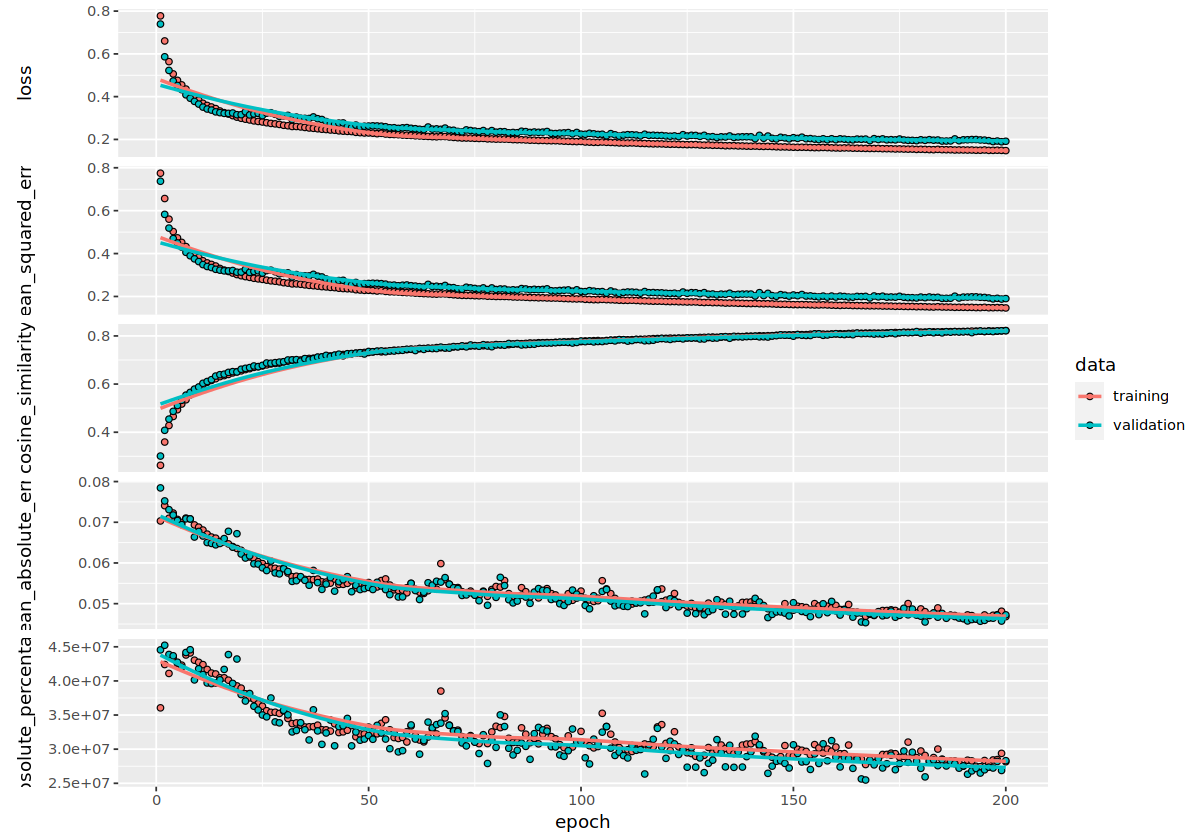

In [87]:
# plot the training and validation loss
plot(history_encoder)


In [79]:
# check the performance on the test set
autoencoder %>% evaluate(test, test)

loss             mean_squared_error              cosine_similarity            mean_absolute_error mean_absolute_percentage_error 
                  1.802229e-01                   1.793082e-01                   8.636221e-01                   3.745537e-02                   2.046271e+07

In [80]:
# save the model
save_model_hdf5(autoencoder, "/work/postresearch/Shared/Projects/Farbod/Clustering/autoencoder.h5")

In [81]:
# read the model
autoencoder <- keras::load_model_hdf5("/work/postresearch/Shared/Projects/Farbod/Clustering/autoencoder.h5")

In [82]:
# extract the weights of the encoder
autoencoder_weights <-
    autoencoder %>%
    keras::get_weights()

save_model_weights_hdf5(object = autoencoder, filepath = "/work/postresearch/Shared/Projects/Farbod/Clustering/autoencoder_weights.h5", overwrite = TRUE)

In [83]:
encoder_model <- keras_model(inputs = input_layer, outputs = encoder)

encoder_model %>% load_model_weights_hdf5(
    filepath = "/work/postresearch/Shared/Projects/Farbod/Clustering/autoencoder_weights.h5",
    skip_mismatch = TRUE, by_name = TRUE
)

encoder_model %>% compile( 
    optimizer = optimizer_adam(learning_rate = 0.01),
    loss = "binary_crossentropy",
    metrics = c("binary_accuracy", "AUC")
)

# save the encoder
save_model_hdf5(encoder_model, "/work/postresearch/Shared/Projects/Farbod/Clustering/encoder.h5")

In [37]:
# get the latent space representation of the whole dataset
wide_data_presence_for_prediction <- as.matrix(wide_data_presence[, -c(1, 2)])

latent_space_representation <- encoder_model %>% predict(wide_data_presence_for_prediction, batch_size = 100)

# add the id and year back
latent_space_representation <- cbind(wide_data_presence_id_year, latent_space_representation) %>% as.data.table()

head(latent_space_representation)

ERROR: Error in as.matrix(wide_data_presence[, -c(1, 2)]): object 'wide_data_presence' not found


In [84]:
# get the latent space representation of the whole dataset
wide_data_for_prediction <- as.matrix(wide_data[, -c(1, 2)])

latent_space_representation <- encoder_model %>% predict(wide_data_for_prediction, batch_size = 100)

# add the id and year back
latent_space_representation <- cbind(wide_data_id_year, latent_space_representation) %>% as.data.table()

head(latent_space_representation)

id,year,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,0.023478318,-0.032408096,0.037043586,-0.047867946,-0.0270334948,0.12834276,-0.01991430,0.096860163,-0.003302645,-0.03741235,-0.05915026,0.01775064,0.01879212,0.0514625013,-0.019539222,0.036773849,0.064834386,0.04727159,-0.007813636,-0.004490947,-0.02615152,-0.013672781,0.0005380278,0.02406533,0.0468432121,0.07198254,0.0272437222,0.06445600,-0.04553934,0.040703289,0.013904938,-0.01222980,-0.04804897,0.03074706,-0.050340500,-0.005571145,-0.029755663,0.071645223,0.03198978,-0.048686177,0.041678287,0.00678126,0.03642640,-0.05032435,0.048254192,0.0004759124,0.031661365,0.01994108,0.01782108,0.07084125
100000019,2016,0.025703661,0.035654377,0.038250662,0.049486078,0.0829092488,-0.15064855,-0.13311037,-0.021063097,-0.073965631,0.02333082,-0.09209070,-0.01186978,0.18901256,0.0200391822,-0.062105682,0.023636475,-0.003324646,0.03880559,0.078162074,0.037704602,-0.12977947,-0.002766354,0.0874455869,-0.03446434,0.0002909424,-0.03529513,0.0009018974,0.01021196,0.00348163,0.016816311,-0.004972470,-0.03241539,0.05348056,0.03099647,-0.012893390,0.015848383,0.035678636,0.130898178,-0.07274987,-0.035380460,0.024616474,0.10553024,0.04786825,0.04863662,-0.028755412,0.0403393954,0.088257596,-0.12408413,-0.10760880,0.01904794
100000053,2016,0.066811815,0.062161360,0.070967905,0.035803385,-0.0083605703,0.08234168,-0.01010134,0.058288712,0.031541970,-0.02355942,-0.06185502,0.10782919,-0.04271817,-0.0449944697,-0.035438348,0.050378729,-0.006093065,-0.03457951,-0.037510399,-0.016393542,0.04877996,0.023555305,-0.0086414488,-0.02402073,-0.0542126559,0.03090607,-0.0097374339,0.06617136,0.05645720,0.038159717,0.027961962,-0.02366737,0.02270065,-0.01314839,-0.002943696,0.012843379,0.019139502,-0.049195629,-0.05244537,0.002190914,0.009694109,-0.00546555,0.03249654,0.03603854,0.008700317,0.0103297979,0.006367964,0.05144013,0.04959679,0.03550173
100000099,2016,-0.012448756,0.174493223,0.142539382,0.131180182,-0.0627932325,0.00947166,-0.27158663,-0.238421515,-0.202262312,0.18538687,0.01175238,-0.06008480,0.20916061,-0.0792016238,0.130660504,-0.241859317,-0.086369283,-0.04117697,-0.161882982,0.147581056,0.09470015,-0.108452670,-0.0230580531,-0.01880855,0.2143623084,0.04969899,0.1368062198,0.14451587,-0.09064016,-0.229545772,-0.073803991,0.08226004,0.03305154,0.12034224,-0.184634313,0.114935383,-0.121598750,-0.099170759,0.31021109,-0.133921802,-0.021639762,-0.06013589,0.03602999,-0.01501607,0.001175759,0.1904320270,0.159359232,-0.09125015,0.13790204,0.10864893
100000203,2016,0.061227240,0.100337394,0.006431272,0.047227934,-0.0307664406,0.16123220,-0.13907222,-0.091377594,-0.146369129,0.08620742,0.13107622,-0.02557202,0.02154962,-0.0028871233,0.058479089,-0.100823894,-0.028364338,0.06263598,-0.117050111,0.002192972,-0.03700852,-0.003801994,-0.0490586050,-0.09896559,0.1421343535,-0.04691717,0.0075202594,-0.01631312,-0.20032106,-0.136401504,-0.003808836,-0.03049145,0.06358233,0.05648738,-0.090133756,-0.025501035,-0.008957461,0.041290168,0.12919357,-0.055804238,-0.011930877,-0.02143210,-0.12165149,0.10090410,-0.001958566,0.0991127044,-0.009839855,0.11925493,0.06448429,0.03664756
100000221,2016,0.005789267,-0.001940837,-0.006679717,0.008306122,0.0009333165,-0.01811846,0.02773709,-0.001893183,-0.010353830,-0.02945770,0.01427956,-0.04604204,-0.05032130,0.0001577763,0.006263838,-0.004169435,-0.015887374,-0.02624739,0.022169761,-0.037927508,0.03621705,-0.008273070,-0.0020479131,0.02221020,-0.0147012714,0.01525889,-0.0180983525,-0.03089396,0.03406363,-0.0087

In [85]:
dim(latent_space_representation)

[1] 1845299      52

In [86]:
# save the latent space representation
write_fst(latent_space_representation, "/work/postresearch/Shared/Projects/Farbod/Clustering/latent_space_representation_2016.fst")

# Clustering

## Using Autoencoder

In [4]:
coords_pred <- read_fst("/work/postresearch/Shared/Projects/Farbod/Clustering/latent_space_representation_2016.fst", as.data.table = TRUE)

In [5]:
#z score nomaalization
coords_pred <-
    coords_pred %>%
    mutate_at(vars(-c("id", "year")),
    scale, center = TRUE, scale = TRUE) %>%
    as.data.table()

library(DescTools)
coords_pred <-
    coords_pred %>%
    mutate_at(vars(-c("id", "year")),
    Winsorize, probs = c(0.05, 0.95)) %>%
    as.data.table()


Attaching package: ‘DescTools’


The following object is masked from ‘package:data.table’:

    %like%




In [6]:
head(coords_pred)

id,year,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,0.28502748,-0.7338440,0.6945998,-0.9257414,-0.45127434,1.4609945,-0.1361339383,1.32529248,0.02514797,-0.5392433,-1.1023339,0.2505175,0.2769895,1.06509190,-0.4068062,0.6127965,1.32961447,1.0267316,-0.06513113,0.0338853,-0.5966149,-0.14281556,0.06188911,0.2605429,0.8909764,1.2836625,0.52642258,1.2072610,-0.85386570,0.6865156,0.24401251,-0.2297211,-0.8494125,0.80882695,-0.77828697,-0.2514136,-0.374601328,1.187544727,0.7362428,-1.1251939,0.93331306,0.26162100,0.6596919,-0.6946704,0.84973081,0.11792136,0.50400570,0.2477041,0.3213873,1.4074815
100000019,2016,0.31705937,0.5730297,0.7156239,0.7190268,1.23165401,-0.9048505,-1.6102015228,-0.41175196,-0.82569187,0.6689049,-1.3432735,-0.1251466,1.5994647,0.47101453,-1.1982180,0.3654325,0.08517818,0.8714956,0.65782147,0.7594232,-1.4592983,0.02772974,1.34039013,-0.8014515,0.1049194,-0.6578360,0.07078308,0.2665445,-0.08631378,0.2523796,-0.07551748,-0.6275663,1.1299166,0.81384075,-0.08033285,0.2143011,0.813028109,1.187544727,-0.8446801,-0.8759939,0.59409461,1.46655971,0.8381233,0.5541581,-0.41565823,0.87109635,1.11526141,-1.3853640,-1.3622328,0.4709414
100000053,2016,0.87735903,1.0819926,1.2854731,0.4878616,-0.12184765,1.3737887,0.0009228031,1.01103865,0.55405594,-0.2637162,-1.1521980,1.3929483,-0.5377420,-0.75848707,-0.7230681,0.8689631,0.02843133,-0.4741235,-0.44474110,-0.1707757,0.7676069,0.43932513,-0.10415294,-0.6119570,-0.8153996,0.5934852,-0.11324743,1.2370092,0.74315773,0.6402872,0.48194989,-0.4551484,0.5298590,-0.07358062,0.10511350,0.1489647,0.512843609,-1.047888235,-0.8323061,-0.1723273,0.29741209,0.02879693,0.5984072,0.3771140,0.19979836,0.30409927,0.02598527,0.6861233,0.9704698,0.7684631
100000099,2016,-0.23211170,1.1236415,1.3168842,1.0072739,-1.08214561,0.1809831,-1.6102015228,-1.01012646,-0.82569187,1.5478620,0.2048023,-0.7366387,1.5994647,-1.17933791,1.1701673,-1.3362770,-1.01451443,-0.5950971,-1.53200394,1.3940494,0.9528374,-1.00770014,-0.36492624,-0.5173842,1.3868433,0.9487050,1.24603820,1.6149789,-1.56003739,-0.9754887,-1.22733894,1.3145037,0.7316506,1.40388517,-1.10903642,1.2002336,-0.916386437,-1.258834476,1.5883197,-1.6072422,-0.32555965,-0.87219451,0.6535100,-0.3403698,0.07615803,1.24601405,1.11526141,-1.2999094,1.0951494,1.5313827
100000203,2016,0.82839058,1.1236415,0.1614130,0.6808761,-0.51713075,1.4609945,-1.6102015228,-1.01012646,-0.82569187,1.5478620,1.1088420,-0.2989266,0.3135138,0.03757848,1.1451166,-1.3362770,-0.42808340,1.3084593,-1.46148721,0.1488130,-0.7942801,0.01153529,-0.83523461,-1.4651674,1.3868433,-0.8775134,0.18526214,-0.1934615,-1.58600567,-0.9754887,-0.05582114,-0.5896466,1.3256302,1.32627125,-1.10903642,-0.6847399,0.002885065,0.818896363,1.5883197,-1.2585066,-0.13253017,-0.27474313,-0.8648257,1.2886867,0.02465614,1.24601405,-0.28032660,0.8058192,1.0951494,0.7891822
100000221,2016,0.03040888,-0.1488394,-0.0669463,0.0233033,0.04211457,-0.2706383,0.5294088646,-0.06803234,-0.08188229,-0.3810298,0.2513924,-0.5585399,-0.6384490,0.09514419,0.1064625,-0.1581256,-0.17233161,-0.3213423,0.31814286,-0.5410448,0.5388833,-0.05837953,0.01511357,0.2268824,-0.1482312,0.2977254,-0.25786781,-0.4463267,0.39252763,-0.2114475,0.11126272,-0.2537978,-0.1370221,-0.36245983,0.02139489,0.1634709,-0.275124191,-0.006910558,-0.3425387,0.4628872,0.03385331,-0.29347212,-0.4779417,-0.3151045,-0.29232902,0.04091179,-0.01789908,0.2698296,0.2343261,-0.3107763


Loading required package: gtools



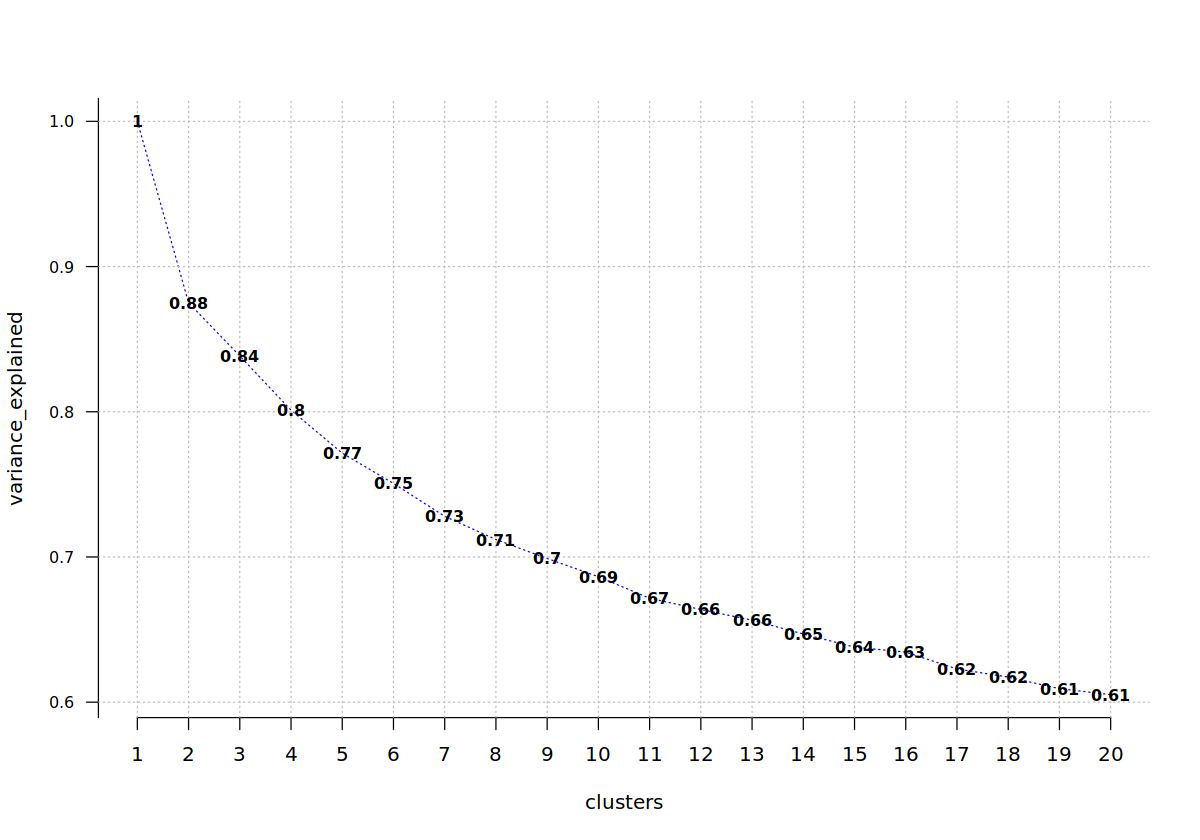

In [7]:
# run elbow method to find the optimal number of clusters
library(ClusterR)
optimal_clusters <- Optimal_Clusters_KMeans(coords_pred[1:10000, -c(1, 2)], max_clusters = 20, initializer = "kmeans++")

In [8]:
library(ClusterR)
kmeans_results <-
    KMeans_rcpp(coords_pred[, -c(1, 2)], 10, initializer = "kmeans++")

In [9]:
summary(kmeans_results)

                        Length  Class  Mode   
call                          4 -none- call   
clusters                1845299 -none- numeric
centroids                   500 -none- numeric
total_SSE                     1 -none- numeric
best_initialization           1 -none- numeric
WCSS_per_cluster             10 -none- numeric
obs_per_cluster              10 -none- numeric
between.SS_DIV_total.SS       1 -none- numeric

In [10]:
coords_pred <- cbind(coords_pred, kmeans_results$cluster)
# change last colname to cluster
colnames(coords_pred)[ncol(coords_pred)] <- "cluster"
head(coords_pred)

id,year,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,cluster
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,0.28502748,-0.7338440,0.6945998,-0.9257414,-0.45127434,1.4609945,-0.1361339383,1.32529248,0.02514797,-0.5392433,-1.1023339,0.2505175,0.2769895,1.06509190,-0.4068062,0.6127965,1.32961447,1.0267316,-0.06513113,0.0338853,-0.5966149,-0.14281556,0.06188911,0.2605429,0.8909764,1.2836625,0.52642258,1.2072610,-0.85386570,0.6865156,0.24401251,-0.2297211,-0.8494125,0.80882695,-0.77828697,-0.2514136,-0.374601328,1.187544727,0.7362428,-1.1251939,0.93331306,0.26162100,0.6596919,-0.6946704,0.84973081,0.11792136,0.50400570,0.2477041,0.3213873,1.4074815,2
100000019,2016,0.31705937,0.5730297,0.7156239,0.7190268,1.23165401,-0.9048505,-1.6102015228,-0.41175196,-0.82569187,0.6689049,-1.3432735,-0.1251466,1.5994647,0.47101453,-1.1982180,0.3654325,0.08517818,0.8714956,0.65782147,0.7594232,-1.4592983,0.02772974,1.34039013,-0.8014515,0.1049194,-0.6578360,0.07078308,0.2665445,-0.08631378,0.2523796,-0.07551748,-0.6275663,1.1299166,0.81384075,-0.08033285,0.2143011,0.813028109,1.187544727,-0.8446801,-0.8759939,0.59409461,1.46655971,0.8381233,0.5541581,-0.41565823,0.87109635,1.11526141,-1.3853640,-1.3622328,0.4709414,9
100000053,2016,0.87735903,1.0819926,1.2854731,0.4878616,-0.12184765,1.3737887,0.0009228031,1.01103865,0.55405594,-0.2637162,-1.1521980,1.3929483,-0.5377420,-0.75848707,-0.7230681,0.8689631,0.02843133,-0.4741235,-0.44474110,-0.1707757,0.7676069,0.43932513,-0.10415294,-0.6119570,-0.8153996,0.5934852,-0.11324743,1.2370092,0.74315773,0.6402872,0.48194989,-0.4551484,0.5298590,-0.07358062,0.10511350,0.1489647,0.512843609,-1.047888235,-0.8323061,-0.1723273,0.29741209,0.02879693,0.5984072,0.3771140,0.19979836,0.30409927,0.02598527,0.6861233,0.9704698,0.7684631,4
100000099,2016,-0.23211170,1.1236415,1.3168842,1.0072739,-1.08214561,0.1809831,-1.6102015228,-1.01012646,-0.82569187,1.5478620,0.2048023,-0.7366387,1.5994647,-1.17933791,1.1701673,-1.3362770,-1.01451443,-0.5950971,-1.53200394,1.3940494,0.9528374,-1.00770014,-0.36492624,-0.5173842,1.3868433,0.9487050,1.24603820,1.6149789,-1.56003739,-0.9754887,-1.22733894,1.3145037,0.7316506,1.40388517,-1.10903642,1.2002336,-0.916386437,-1.258834476,1.5883197,-1.6072422,-0.32555965,-0.87219451,0.6535100,-0.3403698,0.07615803,1.24601405,1.11526141,-1.2999094,1.0951494,1.5313827,7
100000203,2016,0.82839058,1.1236415,0.1614130,0.6808761,-0.51713075,1.4609945,-1.6102015228,-1.01012646,-0.82569187,1.5478620,1.1088420,-0.2989266,0.3135138,0.03757848,1.1451166,-1.3362770,-0.42808340,1.3084593,-1.46148721,0.1488130,-0.7942801,0.01153529,-0.83523461,-1.4651674,1.3868433,-0.8775134,0.18526214,-0.1934615,-1.58600567,-0.9754887,-0.05582114,-0.5896466,1.3256302,1.32627125,-1.10903642,-0.6847399,0.002885065,0.818896363,1.5883197,-1.2585066,-0.13253017,-0.27474313,-0.8648257,1.2886867,0.02465614,1.24601405,-0.28032660,0.8058192,1.0951494,0.7891822,8
100000221,2016,0.03040888,-0.1488394,-0.0669463,0.0233033,0.04211457,-0.2706383,0.5294088646,-0.06803234,-0.08188229,-0.3810298,0.2513924,-0.5585399,-0.6384490,0.09514419,0.1064625,-0.1581256,-0.17233161,-0.3213423,0.31814286,-0.5410448,0.5388833,-0.05837953,0.01511357,0.2268824,-0.1482312,0.2977254,-0.25786781,-0.4463267,0.39252763,-0.2114475,0.11126272,-0.2537978,-0.1370221,-0.36245983,0.02139489,0.1634709,-0.275124191,-0.006910558,-0.3425387,0.4628872,0.03385331,-0.29347212,-0.4779417,-0.3151045,-0.29232902,0.04091179,-0.01789908,0.2698296,0.2343261,-0.3107763,1



Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




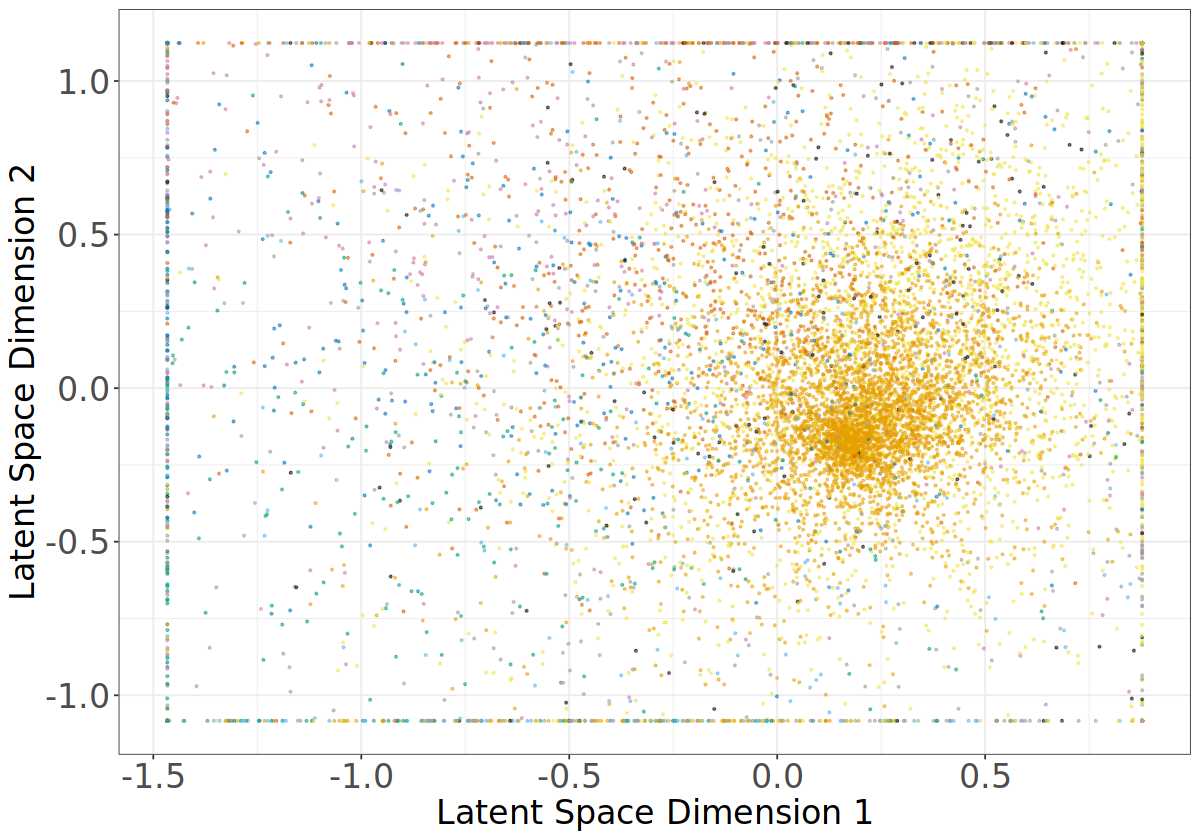

In [11]:
# sample data for gplot
coords_pred_sample <- coords_pred[sample(.N, 10000), ]

# plot the clusters
library(ggplot2)
library(ggrepel)
library(ggsci)
library(ggpubr)
library(gridExtra)
library(grid)

# plot the clusters and x limit to -0.5 to 0.5 and y limit to -0.5 to 0.5
ggplot(coords_pred_sample, aes(x = V1, y = V2, color = factor(cluster))) +
    geom_point(size = 0.5, alpha = 0.5) +
    scale_color_manual(values = c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000", "#999999", "#E69F00")) +
    theme_bw() +
    theme(legend.position = "none") +
    labs(x = "Latent Space Dimension 1", y = "Latent Space Dimension 2") +
    theme(
        axis.text = element_text(size = 20),
        axis.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 20)
    )


In [12]:
wide_data_presence <- read.fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/wide_data_presence_2016.fst",
    as.data.table = TRUE
)

wide_data_presence$cluster = kmeans_results$cluster

In [13]:
# save the cluster
write_fst(wide_data_presence, "/work/postresearch/Shared/Projects/Farbod/Clustering/wide_data_presence_cluster_2016.fst")

In [14]:
head(wide_data_presence)

id,year,A02,A03,A04,A05,A06,A07,A08,A09,A15,A18,A23,A25,A28,A30,A31,A32,A36,A37,A38,A39,A40,A41,A42,A43,A46,A48,A49,A50,A51,A52,A53,A54,A56,A59,A60,A63,A68,A69,A74,A75,A77,A79,A80,A81,A83,A86,A87,A88,A92,A93,A95,B00,B01,B02,B07,B08,B09,B10,B15,B16,B17,B18,B19,B20,B25,B26,B27,B30,B33,B34,B35,B36,B37,B38,B39,B40,B44,B45,B46,B47,B48,B49,B50,B57,B58,B59,B60,B69,B72,B78,B81,B83,B85,B86,B87,B88,B89,B90,B91,B94,B95,B96,B97,B99,C00,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C30,C31,C32,C33,C34,C37,C38,C40,C41,C43,C44,C45,C46,C47,C48,C49,C50,⋯,V63,V73,V78,V79,V88,V94,W04,W21,W27,W28,W29,W32,W33,W39,W46,W52,W53,W60,W61,W89,W90,X00,X01,X02,X10,X12,X13,X15,X18,X32,X52,Y00,Y03,Y09,Y24,Y27,Y29,Y30,A82,B52,B68,C58,G07,G41,N24,O01,O31,P10,P12,P23,P51,P54,P55,P84,Q00,V46,V74,V84,V90,V91,V95,V97,V98,V99,W03,W24,W35,W37,W40,W56,W86,W94,X04,X35,X39,X72,X94,Y23,Y32,Y62,A89,O07,P03,P37,P39,P58,P60,P81,V05,V16,V62,V69,V70,V81,V85,W09,W15,W99,X06,X37,X93,Y38,Y80,A22,A34,A65,A99,B04,B79,F35,F62,H45,O29,O89,P00,P01,P02,P04,P22,P26,P36,P52,P57,P77,S17,T64,V06,W85,X40,Y64,Z05,Z38,B92,E33,H48,K67,M78,P93,V20,B12,H22,I14,J29,M52,P95,V32,V76,V82,V96,cluster
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
100000019,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [15]:
clustering_results <- wide_data_presence[, .(cluster, id, year), by = c("id", "year")]

# save the clustering results
write_fst(clustering_results, "/work/postresearch/Shared/Projects/Farbod/Clustering/clustering_results_2016.fst")

## Using PCA

In [ ]:
# winsorise all dims of coords_pred
coords_pred <- pca_results$ind$coord
#add year and id
coords_pred <- cbind(wide_data[, c("id", "year")], coords_pred)
library(DescTools)
coords_pred <-
    coords_pred %>%
    mutate_at(vars(-c("id", "year")),
    Winsorize, probs = c(0.05, 0.95)) %>%
    as.data.table()


Attaching package: ‘DescTools’


The following object is masked from ‘package:data.table’:

    %like%




In [ ]:
library(ClusterR)
kmeans_results <-
    KMeans_rcpp(coords_pred[, -c(1, 2)], 10, initializer = "kmeans++")

Loading required package: gtools



In [ ]:
summary(kmeans_results)

                        Length Class  Mode   
call                         4 -none- call   
clusters                500000 -none- numeric
centroids                 1000 -none- numeric
total_SSE                    1 -none- numeric
best_initialization          1 -none- numeric
WCSS_per_cluster            10 -none- numeric
obs_per_cluster             10 -none- numeric
between.SS_DIV_total.SS      1 -none- numeric

In [ ]:
wide_data_presence$cluster = kmeans_results$cluster

## Exploratory data analysis

In [16]:
# number of people in each cluster
wide_data_presence[, .N, by = cluster][order(-N)]

cluster,N
<dbl>,<int>
1,792875
4,437145
9,134157
6,132647
7,80118
2,67091
5,65811
3,52928
10,41744


In [17]:
# presence of digestive tract cancer in each of the clusters
cancer_codes <-
    colnames(wide_data_presence) %in%
    c("C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26")

#colnames(wide_data_presence)[cancer_codes]

wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes], "cluster"), with = F][, lapply(.SD, mean), by = cluster][, .(mean = rowMeans(.SD)), by = cluster][order(-mean)]

# what percent of cancer patients are in each cluster
total_cancer <- wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes]), with = F][, (rowSums(.SD) > 0) * 1] %>% sum()
total_cancer
wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes], "cluster"), with = F][, sum(rowSums(.SD) > 0) / total_cancer, by = cluster][order(-V1)]


cluster,mean
<dbl>,<dbl>
2,0.005745927
10,0.003104239
9,0.003081588
7,0.002844762
6,0.001549853
8,0.001487548
4,0.001415244
5,0.001252324
3,0.001089530


[1] 27555

cluster,V1
<dbl>,<dbl>
1,0.25058973
4,0.22602069
9,0.13453094
2,0.11660316
7,0.07933224
6,0.07432408
10,0.04503720
5,0.03012158
3,0.02195609


In [32]:
# presence of digestive tract cancer in each of the clusters
cancer_codes <-
    colnames(wide_data_presence) %in%
    c("C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26")

#colnames(wide_data_presence)[cancer_codes]

wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes], "cluster"), with = F][, lapply(.SD, mean), by = cluster][, .(mean = rowMeans(.SD)), by = cluster][order(-mean)]

# what percent of cancer patients are in each cluster
total_cancer <- wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes]), with = F][, (rowSums(.SD) > 0) * 1] %>% sum()
total_cancer
wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes], "cluster"), with = F][, sum(rowSums(.SD) > 0) / total_cancer, by = cluster][order(-V1)]


cluster,mean
<dbl>,<dbl>
7,5.227843e-03
4,2.993082e-03
2,2.648181e-03
8,1.498319e-03
5,1.389118e-03
3,7.307119e-04
10,6.112110e-04
9,4.556944e-04
6,2.672406e-04


[1] 27555

cluster,V1
<dbl>,<dbl>
7,3.061150e-01
4,2.072219e-01
2,1.314462e-01
8,9.856650e-02
5,9.519144e-02
3,6.481582e-02
9,4.057340e-02
10,3.186355e-02
6,2.413355e-02


In [18]:
# presence of MI in each of the clusters
mi_codes <-
    colnames(wide_data_presence) %in%
    c("I21")

# colnames(wide_data_presence)[mi_codes]

wide_data_presence[, c(colnames(wide_data_presence)[mi_codes], "cluster"), with = F][, lapply(.SD, mean), by = cluster][, .(mean = rowMeans(.SD)), by = cluster][order(-mean)]

# what percent of MI patients are in each cluster
total_mi <- wide_data_presence[, c(colnames(wide_data_presence)[mi_codes]), with = F][, (rowSums(.SD) > 0) * 1] %>% sum()
total_mi
wide_data_presence[, c(colnames(wide_data_presence)[mi_codes], "cluster"), with = F][, sum(rowSums(.SD) > 0) / total_mi, by = cluster][order(-V1)]

cluster,mean
<dbl>,<dbl>
10,0.081688386
7,0.056678899
9,0.049844585
6,0.023196906
2,0.019749296
4,0.015713322
3,0.013716747
8,0.013559571
5,0.010499764


[1] 32378

cluster,V1
<dbl>,<dbl>
4,0.21215023
9,0.20652912
7,0.14024955
1,0.13895238
10,0.10531843
6,0.09503366
2,0.04092285
3,0.02242263
5,0.02134165


In [20]:
# presence of schizophrenia in each of the clusters

mental_codes <-
    colnames(wide_data_presence) %in%
    c("F20", "F21", "F22", "F23", "F24", "F25", "F26", "F27", "F28", "F29")
# colnames(wide_data_presence)[mental_codes]

wide_data_presence[, c(colnames(wide_data_presence)[mental_codes], "cluster"), with = F][, lapply(.SD, mean), by = cluster][, .(mean = rowMeans(.SD)), by = cluster][order(-mean)]

# what percent of mental patients are in each cluster
total_mental <- wide_data_presence[, c(colnames(wide_data_presence)[mental_codes]), with = F][, (rowSums(.SD) > 0) * 1] %>% sum()
total_mental
wide_data_presence[, c(colnames(wide_data_presence)[mental_codes], "cluster"), with = F][, sum(rowSums(.SD) > 0) / total_mental, by = cluster][order(-V1)]

cluster,mean
<dbl>,<dbl>
10,0.016575118
3,0.004790882
6,0.004160096
9,0.004054816
5,0.002687301
7,0.002684759
1,0.002681983
4,0.002663037
2,0.001660410


[1] 44710

cluster,V1
<dbl>,<dbl>
1,0.32959070
10,0.25099530
6,0.23703869
3,0.07984791
9,0.02335048
7,0.02140461
4,0.01827332
2,0.01549989
5,0.01355401


## Predict clusters for the rest of the wide data

In [ ]:
wide_data_presence <- read.fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/wide_data_presence_2016.fst",
    as.data.table = TRUE
)

In [ ]:
# predict PCAs
wide_data_after_pca <-
    predict(pca_results, wide_data_presence[, -c("id", "year")])

ERROR: Error in UseMethod("tbl_vars"): no applicable method for 'tbl_vars' applied to an object of class "list"


In [ ]:
str(wide_data_after_pca)

List of 3
 $ coord: num [1:1845299, 1:100] 0.869 -2.103 -2.155 5.647 4.918 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:100] "Dim.1" "Dim.2" "Dim.3" "Dim.4" ...
 $ cos2 : num [1:1845299, 1:100] 0.000825 0.016165 0.027139 0.002909 0.027123 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:100] "Dim.1" "Dim.2" "Dim.3" "Dim.4" ...
 $ dist : num [1:1845299] 30.2 16.5 13.1 104.7 29.9 ...


In [ ]:
# winsorize
library(DescTools)
wide_data_after_pca <-
    wide_data_after_pca$coord %>%
    as.data.table() %>%
    mutate_all(
        Winsorize, probs = c(0.05, 0.95)
    ) %>%
    as.data.table()

In [ ]:
# predict clusters
kmeans_whole_wide_data <- predict(kmeans_results, wide_data_after_pca,
    threads = numcores
)
# create a data table with only id, year, and cluster
results_clustering_whole_data <- data.table(
    id = wide_data_presence$id,
    year = wide_data_presence$year,
    cluster = kmeans_whole_wide_data
)

wide_data$cluster <- kmeans_whole_wide_data
# save the data to fst
write.fst(results_clustering_whole_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/results_clustering_whole_data.fst")

In [ ]:
head(results_clustering_whole_data)

id,year,cluster
<int>,<dbl>,<dbl>
100000015,2016,2
100000019,2016,6
100000053,2016,6
100000099,2016,1
100000203,2016,1
100000221,2016,9


In [ ]:
wide_data_presence$cluster <- kmeans_whole_wide_data

### Exploratory analyses on the whole data

In [ ]:
# number of people in each cluster
wide_data_presence[, .N, by = cluster][order(-N)]

cluster,N
<dbl>,<int>
9,615044
6,449941
7,148717
3,127958
4,106149
2,101748
10,83332
8,78781
1,70226


In [ ]:
# presence of digestive tract cancer in each of the clusters
cancer_codes <-
    colnames(wide_data_presence) %in%
    c("C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26")

#colnames(wide_data_presence)[cancer_codes]

wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes], "cluster"), with = F][, lapply(.SD, mean), by = cluster][, .(mean = rowMeans(.SD)), by = cluster][order(-mean)]

# what percent of cancer patients are in each cluster
total_cancer <- wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes]), with = F][, (rowSums(.SD) > 0) * 1] %>% sum()
total_cancer
wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes], "cluster"), with = F][, sum(rowSums(.SD) > 0) / total_cancer, by = cluster][order(-V1)]


cluster,mean
<dbl>,<dbl>
4,0.0093249426
10,0.0080181283
1,0.0025928194
8,0.0009763352
2,0.0009246701
3,0.0007893215
5,0.0006164272
6,0.0006100800
9,0.0005610710


[1] 27555

cluster,V1
<dbl>,<dbl>
4,0.32669207
10,0.20711305
9,0.13630920
6,0.11232081
1,0.06289240
3,0.04144438
2,0.03908547
8,0.03048449
7,0.02739975


In [ ]:
# presence of MI in each of the clusters
mi_codes <-
    colnames(wide_data_presence) %in%
    c("I21")

# colnames(wide_data_presence)[mi_codes]

wide_data_presence[, c(colnames(wide_data_presence)[mi_codes], "cluster"), with = F][, lapply(.SD, mean), by = cluster][, .(mean = rowMeans(.SD)), by = cluster][order(-mean)]

# what percent of MI patients are in each cluster
total_mi <- wide_data_presence[, c(colnames(wide_data_presence)[mi_codes]), with = F][, (rowSums(.SD) > 0) * 1] %>% sum()
total_mi
wide_data_presence[, c(colnames(wide_data_presence)[mi_codes], "cluster"), with = F][, sum(rowSums(.SD) > 0) / total_mi, by = cluster][order(-V1)]

cluster,mean
<dbl>,<dbl>
10,0.149858398
2,0.090134450
1,0.049554296
5,0.019147359
4,0.011465016
7,0.005426414
3,0.004259210
8,0.003630317
9,0.003095713


[1] 32378

cluster,V1
<dbl>,<dbl>
10,0.385693990
2,0.283247884
1,0.107480388
9,0.058805362
6,0.039100624
4,0.037587251
5,0.037494595
7,0.024924331
3,0.016832417


In [ ]:
# presence of schizophrenia in each of the clusters

mental_codes <-
    colnames(wide_data_presence) %in%
    c("F20", "F21", "F22", "F23", "F24", "F25", "F26", "F27", "F28", "F29")
# colnames(wide_data_presence)[mental_codes]

wide_data_presence[, c(colnames(wide_data_presence)[mental_codes], "cluster"), with = F][, lapply(.SD, mean), by = cluster][, .(mean = rowMeans(.SD)), by = cluster][order(-mean)]

# what percent of mental patients are in each cluster
total_mental <- wide_data_presence[, c(colnames(wide_data_presence)[mental_codes]), with = F][, (rowSums(.SD) > 0) * 1] %>% sum()
total_mental
wide_data_presence[, c(colnames(wide_data_presence)[mental_codes], "cluster"), with = F][, sum(rowSums(.SD) > 0) / total_mental, by = cluster][order(-V1)]

cluster,mean
<dbl>,<dbl>
5,0.0217359589
1,0.0185561615
10,0.0111436783
9,0.0035084888
8,0.0027338445
7,0.0023551443
6,0.0021024979
4,0.0020278100
2,0.0014742305


[1] 44710

cluster,V1
<dbl>,<dbl>
9,0.312077835
5,0.168642362
1,0.135898009
6,0.131894431
10,0.114582867
7,0.050055916
4,0.030149855
8,0.029545963
2,0.020241557


# Going back to the main data for the rest of the analysis

In [ ]:
# read the data
carrier_data <- read_fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/carrier_data.fst",
    as.data.table = TRUE
)
inpatient_data <- read_fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/inpatient_data.fst",
    as.data.table = TRUE
)
outpatient_data <- read_fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/outpatient_data.fst",
    as.data.table = TRUE
)

clustering_results <- read_fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/clustering_results_2016.fst",
    as.data.table = TRUE
)

In [ ]:
#choose only 2016
carrier_data <- carrier_data[year == 2016, ]
inpatient_data <- inpatient_data[year == 2016, ]
outpatient_data <- outpatient_data[year == 2016, ]

In [ ]:
head(carrier_data)
head(inpatient_data)
head(outpatient_data)
head(clustering_results)

id,diagnosis,provider,provider_specialty,hcpcs,date,cost,year
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
100000015,H3532,1265609275,18,67028,20160129,110.66,2016
100000015,H3532,1265609275,18,J0178,20160129,1961.00,2016
100000015,I10,1730170630,06,99214,20160212,113.64,2016
100000015,I10,1730170630,06,93000,20160212,18.34,2016
100000015,I479,1730170630,06,93457,20160218,371.86,2016
100000015,I252,1730170630,06,99217,20160219,75.37,2016


DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,FI_CLM_ACTN_CD,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_PPS_IND_CD,CLM_TOT_CHRG_AMT,CLM_ADMSN_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,NCH_IP_NCVRD_CHRG_AMT,CLM_TOT_PPS_CPTL_AMT,CLM_PPS_CPTL_FSP_AMT,CLM_PPS_CPTL_OUTLIER_AMT,CLM_PPS_CPTL_DSPRPRTNT_SHR_AMT,CLM_PPS_CPTL_IME_AMT,CLM_PPS_CPTL_EXCPTN_AMT,CLM_PPS_OLD_CPTL_HLD_HRMLS_AMT,CLM_PPS_CPTL_DRG_WT_NUM,CLM_UTLZTN_DAY_CNT,BENE_TOT_COINSRNC_DAYS_CNT,BENE_LRD_USED_CNT,CLM_NON_UTLZTN_DAYS_CNT,NCH_BLOOD_PNTS_FRNSHD_QTY,NCH_VRFD_NCVRD_STAY_FROM_DT,NCH_VRFD_NCVRD_STAY_THRU_DT,NCH_BENE_MDCR_BNFTS_EXHTD_DT_I,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,CLM_DRG_OUTLIER_STAY_CD,NCH_DRG_OUTLIER_APRVD_PMT_AMT,ADMTG_DGNS_CD,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,CLM_POA_IND_SW1,ICD_DGNS_CD2,CLM_POA_IND_SW2,ICD_DGNS_CD3,CLM_POA_IND_SW3,ICD_DGNS_CD4,CLM_POA_IND_SW4,ICD_DGNS_CD5,CLM_POA_IND_SW5,ICD_DGNS_CD6,CLM_POA_IND_SW6,ICD_DGNS_CD7,CLM_POA_IND_SW7,ICD_DGNS_CD8,CLM_POA_IND_SW8,ICD_DGNS_CD9,CLM_POA_IND_SW9,ICD_DGNS_CD10,CLM_POA_IND_SW10,ICD_DGNS_CD11,CLM_POA_IND_SW11,ICD_DGNS_CD12,CLM_POA_IND_SW12,ICD_DGNS_CD13,CLM_POA_IND_SW13,ICD_DGNS_CD14,CLM_POA_IND_SW14,ICD_DGNS_CD15,CLM_POA_IND_SW15,ICD_DGNS_CD16,CLM_POA_IND_SW16,ICD_DGNS_CD17,CLM_POA_IND_SW17,ICD_DGNS_CD18,CLM_POA_IND_SW18,ICD_DGNS_CD19,CLM_POA_IND_SW19,ICD_DGNS_CD20,CLM_POA_IND_SW20,ICD_DGNS_CD21,CLM_POA_IND_SW21,ICD_DGNS_CD22,CLM_POA_IND_SW22,ICD_DGNS_CD23,CLM_POA_IND_SW23,ICD_DGNS_CD24,CLM_POA_IND_SW24,ICD_DGNS_CD25,CLM_POA_IND_SW25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,CLM_E_POA_IND_SW1,ICD_DGNS_E_CD2,CLM_E_POA_IND_SW2,ICD_DGNS_E_CD3,CLM_E_POA_IND_SW3,ICD_DGNS_E_CD4,CLM_E_POA_IND_SW4,ICD_DGNS_E_CD5,CLM_E_POA_IND_SW5,ICD_DGNS_E_CD6,CLM_E_POA_IND_SW6,ICD_DGNS_E_CD7,CLM_E_POA_IND_SW7,ICD_DGNS_E_CD8,CLM_E_POA_IND_SW8,ICD_DGNS_E_CD9,CLM_E_POA_IND_SW9,ICD_DGNS_E_CD10,CLM_E_POA_IND_SW10,ICD_DGNS_E_CD11,CLM_E_POA_IND_SW11,ICD_DGNS_E_CD12,CLM_E_POA_IND_SW12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_IP_LOW_VOL_PMT_AMT,CLM_CARE_IMPRVMT_MODEL_CD1,CLM_CARE_IMPRVMT_MODEL_CD2,CLM_CARE_IMPRVMT_MODEL_CD3,CLM_CARE_IMPRVMT_MODEL_CD4,CLM_BNDLD_MODEL_1_DSCNT_PCT,CLM_BASE_OPRTG_DRG_AMT,CLM_VBP_PRTCPNT_IND_CD,CLM_VBP_ADJSTMT_PCT,CLM_HRR_PRTCPNT_IND_CD,CLM_HRR_ADJSTMT_PCT,CLM_MODEL_4_READMSN_IND_CD,CLM_UNCOMPD_CARE_PMT_AMT,CLM_BNDLD_ADJSTMT_PMT_AMT,CLM_VBP_ADJSTMT_PMT_AMT,CLM_HRR_ADJSTMT_PMT_AMT,EHR_PYMT_ADJSTMT_AMT,PPS_STD_VAL_PYMT_AMT,FINL_STD_AMT,HAC_PGM_RDCTN_IND_SW,EHR_PGM_RDCTN_IND_SW,CLM_SITE_NTRL_PYMT_CST_AMT,CLM_SITE_NTRL_PYMT_IPPS_AMT,CLM_FULL_STD_PYMT_AMT,CLM_SS_OUTLIER_STD_PYMT_AMT,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int

DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,PRVDR_STATE_CD,ORG_NPI_NUM,SRVC_LOC_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,RFR_PHYSN_NPI,RFR_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_TOT_CHRG_AMT,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,ICD_DGNS_CD7,ICD_DGNS_CD8,ICD_DGNS_CD9,ICD_DGNS_CD10,ICD_DGNS_CD11,ICD_DGNS_CD12,ICD_DGNS_CD13,ICD_DGNS_CD14,ICD_DGNS_CD15,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,ICD_DGNS_E_CD2,ICD_DGNS_E_CD3,ICD_DGNS_E_CD4,ICD_DGNS_E_CD5,ICD_DGNS_E_CD6,ICD_DGNS_E_CD7,ICD_DGNS_E_CD8,ICD_DGNS_E_CD9,ICD_DGNS_E_CD10,ICD_DGNS_E_CD11,ICD_DGNS_E_CD12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,RSN_VISIT_CD1,RSN_VISIT_CD2,RSN_VISIT_CD3,NCH_BENE_PTB_DDCTBL_AMT,NCH_BENE_PTB_COINSRNC_AMT,CLM_OP_PRVDR_PMT_AMT,CLM_OP_BENE_PMT_AMT,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,FI_CLM_ACTN_CD,NCH_BLOOD_PNTS_FRNSHD_QTY,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_OP_TRANS_TYPE_CD,CLM_OP_ESRD_MTHD_CD,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<int>,<chr>,<int>,<chr>,<lgl>,<int>,<chr>,<lgl>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<lgl>,<lgl>,<lgl>,<chr>,<dbl>
100000015,2,220071,20160119,W,40,3,1,3,1,14211,,104.26,0,,22,1023049236,NA,,1174560288,11,NA,NA,,NA,NA,,NA,,NA,,NA,1,846.02,0,NA,J449,J449,,,,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,,,0,26.6,104.26,0,4,1,1,160,22,10,1,0,,1,C,0,NA,NA,NA,NA,NA,,2016
100000015,3,220071,20160122,W,40,3,1,3,1,14211,,52.13,0,,22,1023049236,NA,,1174560288,11,NA,NA,,NA,NA,,NA,,NA,,NA,1,423.00,0,NA,J449,J449,,,,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,,,0,13.3,52.13,0,4,1,1,160,22,10,1,0,,1,C,0,NA,NA,NA,NA,NA,,2016
100000015,4,220071,20160126,W,40,3,1,3,1,14211,,52.13,0,,22,1023049236,NA,,1174560288,11,N

id,year,cluster
<int>,<dbl>,<dbl>
100000015,2016,2
100000019,2016,6
100000053,2016,6
100000099,2016,1
100000203,2016,1
100000221,2016,9


In [ ]:
# select only cost, provider, id, year, and cluster
carrier_data <- carrier_data[, c("id", "year", "cost", "provider", "provider_specialty")]
inpatient_data <- inpatient_data[, .(
    id = DESY_SORT_KEY,
    year = year,
    cost = CLM_TOT_CHRG_AMT,
    provider = AT_PHYSN_NPI,
    provider_specialty = AT_PHYSN_SPCLTY_CD
)]

outpatient_data <- outpatient_data[, .(
    id = DESY_SORT_KEY,
    year = year,
    cost = CLM_TOT_CHRG_AMT,
    provider = AT_PHYSN_NPI,
    provider_specialty = AT_PHYSN_SPCLTY_CD
)]

# merge the data
full_data <- rbindlist(list(carrier_data, inpatient_data, outpatient_data), fill = TRUE)


In [61]:
# add clusters
full_data <- full_data[clustering_results, on = c("id", "year")]

# save the data
write.fst(full_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/full_data.fst")

## MBSF data

In [62]:
# Finding outcomes from the mbsf data
mbsf_data <- read_fst("/work/postresearch/Shared/Projects/Data_fst/mbsf_data",
    as.data.table = TRUE
)


In [63]:
tail(mbsf_data)

DESY_SORT_KEY,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_2013,HMO_INDICATOR09_2013,HMO_INDICATOR10_2013,HMO_INDICATOR11_2013,HMO_INDICATOR12_2013,VALID_DATE_OF_DEATH_SWITCH_2013,DATE_OF_DEATH_2013,REFERENCE_YEAR_2014,STATE_CODE_2014,COUNTY_CODE_2014,SEX_CODE_2014,RACE_CODE_2014,AGE_2014,ORIG_REASON_FOR_ENTITLEMENT_2014,CURR_REASON_FOR_ENTITLEMENT_2014,ENTITLEMENT_BUY_IN_IND01_2014,ENTITLEMENT_BUY_IN_IND02_2014,ENTITLEMENT_BUY_IN_IND03_2014,ENTITLEMENT_BUY_IN_IND04_2014,ENTITLEMENT_BUY_IN_IND05_2014,ENTITLEMENT_BUY_IN_IND06_2014,ENTITLEMENT_BUY_IN_IND07_2014,ENTITLEMENT_BUY_IN_IND08_2014,ENTITLEMENT_BUY_IN_IND09_2014,ENTITLEMENT_BUY_IN_IND10_2014,ENTITLEMENT_BUY_IN_IND11_2014,ENTITLEMENT_BUY_IN_IND12_2014,HMO_INDICATOR01_2014,HMO_INDICATOR02_2014,HMO_INDICATOR03_2014,HMO_INDICATOR04_2014,HMO_INDICATOR05_2014,HMO_INDICATOR06_2014,HMO_INDICATOR07_2014,HMO_INDICATOR08_2014,HMO_INDICATOR09_2014,HMO_INDICATOR10_2014,HMO_INDICATOR11_2014,HMO_INDICATOR12_2014,VALID_DATE_OF_DEATH_SWITCH_2014,DATE_OF_DEATH_2014,REFERENCE_YEAR_2015,STATE_CODE_2015,COUNTY_CODE_2015,SEX_CODE_2015,RACE_CODE_2015,AGE_2015,ORIG_REASON_FOR_ENTITLEMENT_2015,CURR_REASON_FOR_ENTITLEMENT_2015,ENTITLEMENT_BUY_IN_IND01_2015,ENTITLEMENT_BUY_IN_IND02_2015,ENTITLEMENT_BUY_IN_IND03_2015,ENTITLEMENT_BUY_IN_IND04_2015,ENTITLEMENT_BUY_IN_IND05_2015,ENTITLEMENT_BUY_IN_IND06_2015,ENTITLEMENT_BUY_IN_IND07_2015,ENTITLEMENT_BUY_IN_IND08_2015,ENTITLEMENT_BUY_IN_IND09_2015,ENTITLEMENT_BUY_IN_IND10_2015,ENTITLEMENT_BUY_IN_IND11_2015,ENTITLEMENT_BUY_IN_IND12_2015,HMO_INDICATOR01_2015,HMO_INDICATOR02_2015,HMO_INDICATOR03_2015,HMO_INDICATOR04_2015,HMO_INDICATOR05_2015,HMO_INDICATOR06_2015,HMO_INDICATOR07_2015,HMO_INDICATOR08_2015,HMO_INDICATOR09_2015,HMO_INDICATOR10_2015,HMO_INDICATOR11_2015,HMO_INDICATOR12_2015,VALID_DATE_OF_DEATH_SWITCH_2015,DATE_OF_DEATH_2015,REFERENCE_YEAR_2016,STATE_CODE_2016,COUNTY_CODE_2016,SEX_CODE_2016,RACE_CODE_2016,AGE_2016,ORIG_REASON_FOR_ENTITLEMENT_2016,CURR_REASON_FOR_ENTITLEMENT_2016,ENTITLEMENT_BUY_IN_IND01_2016,ENTITLEMENT_BUY_IN_IND02_2016,ENTITLEMENT_BUY_IN_IND03_2016,ENTITLEMENT_BUY_IN_IND04_2016,ENTITLEMENT_BUY_IN_IND05_2016,ENTITLEMENT_BUY_IN_IND06_2016,ENTITLEMENT_BUY_IN_IND07_2016,ENTITLEMENT_BUY_IN_IND08_2016,ENTITLEMENT_BUY_IN_IND09_2016,ENTITLEMENT_BUY_IN_IND10_2016,ENTITLEMENT_BUY_IN_IND11_2016,ENTITLEMENT_BUY_IN_IND12_2016,HMO_INDICATOR01_2016,HMO_INDICATOR02_2016,HMO_INDICATOR03_2016,HMO_INDICATOR04_2016,HMO_INDICATOR05_2016,HMO_INDICATOR06_2016,HMO_INDICATOR07_2016,HMO_INDICATOR08_2016,HMO_INDICATOR09_2016,HMO_INDICATOR10_2016,HMO_INDICATOR11_2016,HMO_INDICATOR12_2016,VALID_DATE_OF_DEATH_SWITCH_2016,DATE_OF_DEATH_2016,REFERENCE_YEAR_2017,STATE_CODE_2017,COUNTY_CODE_2017,SEX_CODE_2017,RACE_CODE_2017,AGE_2017,ORIG_REASON_FOR_ENTITLEMENT_2017,CURR_REASON_FOR_ENTITLEMENT_2017,ENTITLEMENT_BUY_IN_IND01_2017,ENTITLEMENT_BUY_IN_IND02_2017,ENTITLEMENT_BUY_IN_IND03_2017,ENTITLEMENT_BUY_IN_IND04_2017,ENTITLEMENT_BUY_IN_IND05_2017,ENTITLEMENT_BUY_IN_IND06_2017,ENTITLEMENT_BUY_IN_IND07_2017,ENTITLEMENT_BUY_IN_IND08_2017,ENTITLEMENT_BUY_IN_IND09_2017,ENTITLEMENT_BUY_IN_IND10_2017,ENTITLEMENT_BUY_IN_IND11_2017,ENTITLEMENT_BUY_IN_IND12_2017,HMO_INDICATOR01_2017,HMO_INDICATOR02_2017,HMO_INDICATOR03_2017,HMO_INDICATOR04_2017,HMO_INDICATOR05_2017,HMO_INDICATOR06_2017,HMO_INDICATOR07_2017,HMO_INDICATOR08_2017,HMO_INDICATOR09_2017,

In [64]:
# Extract data from the mbsf data
mbsf_data <- mbsf_data[, .(
    id = DESY_SORT_KEY,
    state = STATE_CODE_2016,
    county = COUNTY_CODE_2016,
    sex = SEX_CODE_2016,
    race = RACE_CODE_2016,
    age = AGE_2016,
    died_2016 = !is.na(DATE_OF_DEATH_2016),
    died_2017 = !is.na(DATE_OF_DEATH_2017),
    died_2018 = !is.na(DATE_OF_DEATH_2018),
    died_2019 = !is.na(DATE_OF_DEATH_2019),
    died_2020 = !is.na(DATE_OF_DEATH_2020)
)]

In [65]:
head(mbsf_data[died_2018 == T])

id,state,county,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
100002065,22,040,2,1,79,FALSE,FALSE,TRUE,FALSE,FALSE
100003247,32,150,1,6,83,FALSE,FALSE,TRUE,FALSE,FALSE
100003583,46,210,1,1,79,FALSE,FALSE,TRUE,FALSE,FALSE
100006751,10,550,2,1,80,FALSE,FALSE,TRUE,FALSE,FALSE
100007013,33,240,1,1,79,FALSE,FALSE,TRUE,FALSE,FALSE
100008815,05,480,1,3,79,FALSE,FALSE,TRUE,FALSE,FALSE


## Comorbidities

In [28]:
# read the data
carrier_data <- read_fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/carrier_data.fst",
    as.data.table = TRUE
)
inpatient_data <- read_fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/inpatient_data.fst",
    as.data.table = TRUE
)
outpatient_data <- read_fst(
    "/work/postresearch/Shared/Projects/Farbod/Clustering/outpatient_data.fst",
    as.data.table = TRUE
)

In [29]:
#choose only 2016
carrier_data <- carrier_data[year == 2016, ]
inpatient_data <- inpatient_data[year == 2016, ]
outpatient_data <- outpatient_data[year == 2016, ]



In [30]:
head(carrier_data)
head(inpatient_data)
head(outpatient_data)

id,diagnosis,provider,provider_specialty,hcpcs,date,cost,year
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
100000015,H3532,1265609275,18,67028,20160129,110.66,2016
100000015,H3532,1265609275,18,J0178,20160129,1961.00,2016
100000015,I10,1730170630,06,99214,20160212,113.64,2016
100000015,I10,1730170630,06,93000,20160212,18.34,2016
100000015,I479,1730170630,06,93457,20160218,371.86,2016
100000015,I252,1730170630,06,99217,20160219,75.37,2016


DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,FI_CLM_ACTN_CD,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_PPS_IND_CD,CLM_TOT_CHRG_AMT,CLM_ADMSN_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,NCH_IP_NCVRD_CHRG_AMT,CLM_TOT_PPS_CPTL_AMT,CLM_PPS_CPTL_FSP_AMT,CLM_PPS_CPTL_OUTLIER_AMT,CLM_PPS_CPTL_DSPRPRTNT_SHR_AMT,CLM_PPS_CPTL_IME_AMT,CLM_PPS_CPTL_EXCPTN_AMT,CLM_PPS_OLD_CPTL_HLD_HRMLS_AMT,CLM_PPS_CPTL_DRG_WT_NUM,CLM_UTLZTN_DAY_CNT,BENE_TOT_COINSRNC_DAYS_CNT,BENE_LRD_USED_CNT,CLM_NON_UTLZTN_DAYS_CNT,NCH_BLOOD_PNTS_FRNSHD_QTY,NCH_VRFD_NCVRD_STAY_FROM_DT,NCH_VRFD_NCVRD_STAY_THRU_DT,NCH_BENE_MDCR_BNFTS_EXHTD_DT_I,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,CLM_DRG_OUTLIER_STAY_CD,NCH_DRG_OUTLIER_APRVD_PMT_AMT,ADMTG_DGNS_CD,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,CLM_POA_IND_SW1,ICD_DGNS_CD2,CLM_POA_IND_SW2,ICD_DGNS_CD3,CLM_POA_IND_SW3,ICD_DGNS_CD4,CLM_POA_IND_SW4,ICD_DGNS_CD5,CLM_POA_IND_SW5,ICD_DGNS_CD6,CLM_POA_IND_SW6,ICD_DGNS_CD7,CLM_POA_IND_SW7,ICD_DGNS_CD8,CLM_POA_IND_SW8,ICD_DGNS_CD9,CLM_POA_IND_SW9,ICD_DGNS_CD10,CLM_POA_IND_SW10,ICD_DGNS_CD11,CLM_POA_IND_SW11,ICD_DGNS_CD12,CLM_POA_IND_SW12,ICD_DGNS_CD13,CLM_POA_IND_SW13,ICD_DGNS_CD14,CLM_POA_IND_SW14,ICD_DGNS_CD15,CLM_POA_IND_SW15,ICD_DGNS_CD16,CLM_POA_IND_SW16,ICD_DGNS_CD17,CLM_POA_IND_SW17,ICD_DGNS_CD18,CLM_POA_IND_SW18,ICD_DGNS_CD19,CLM_POA_IND_SW19,ICD_DGNS_CD20,CLM_POA_IND_SW20,ICD_DGNS_CD21,CLM_POA_IND_SW21,ICD_DGNS_CD22,CLM_POA_IND_SW22,ICD_DGNS_CD23,CLM_POA_IND_SW23,ICD_DGNS_CD24,CLM_POA_IND_SW24,ICD_DGNS_CD25,CLM_POA_IND_SW25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,CLM_E_POA_IND_SW1,ICD_DGNS_E_CD2,CLM_E_POA_IND_SW2,ICD_DGNS_E_CD3,CLM_E_POA_IND_SW3,ICD_DGNS_E_CD4,CLM_E_POA_IND_SW4,ICD_DGNS_E_CD5,CLM_E_POA_IND_SW5,ICD_DGNS_E_CD6,CLM_E_POA_IND_SW6,ICD_DGNS_E_CD7,CLM_E_POA_IND_SW7,ICD_DGNS_E_CD8,CLM_E_POA_IND_SW8,ICD_DGNS_E_CD9,CLM_E_POA_IND_SW9,ICD_DGNS_E_CD10,CLM_E_POA_IND_SW10,ICD_DGNS_E_CD11,CLM_E_POA_IND_SW11,ICD_DGNS_E_CD12,CLM_E_POA_IND_SW12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_IP_LOW_VOL_PMT_AMT,CLM_CARE_IMPRVMT_MODEL_CD1,CLM_CARE_IMPRVMT_MODEL_CD2,CLM_CARE_IMPRVMT_MODEL_CD3,CLM_CARE_IMPRVMT_MODEL_CD4,CLM_BNDLD_MODEL_1_DSCNT_PCT,CLM_BASE_OPRTG_DRG_AMT,CLM_VBP_PRTCPNT_IND_CD,CLM_VBP_ADJSTMT_PCT,CLM_HRR_PRTCPNT_IND_CD,CLM_HRR_ADJSTMT_PCT,CLM_MODEL_4_READMSN_IND_CD,CLM_UNCOMPD_CARE_PMT_AMT,CLM_BNDLD_ADJSTMT_PMT_AMT,CLM_VBP_ADJSTMT_PMT_AMT,CLM_HRR_ADJSTMT_PMT_AMT,EHR_PYMT_ADJSTMT_AMT,PPS_STD_VAL_PYMT_AMT,FINL_STD_AMT,HAC_PGM_RDCTN_IND_SW,EHR_PGM_RDCTN_IND_SW,CLM_SITE_NTRL_PYMT_CST_AMT,CLM_SITE_NTRL_PYMT_IPPS_AMT,CLM_FULL_STD_PYMT_AMT,CLM_SS_OUTLIER_STD_PYMT_AMT,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int

DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,PRVDR_STATE_CD,ORG_NPI_NUM,SRVC_LOC_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,RFR_PHYSN_NPI,RFR_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_TOT_CHRG_AMT,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,ICD_DGNS_CD7,ICD_DGNS_CD8,ICD_DGNS_CD9,ICD_DGNS_CD10,ICD_DGNS_CD11,ICD_DGNS_CD12,ICD_DGNS_CD13,ICD_DGNS_CD14,ICD_DGNS_CD15,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,ICD_DGNS_E_CD2,ICD_DGNS_E_CD3,ICD_DGNS_E_CD4,ICD_DGNS_E_CD5,ICD_DGNS_E_CD6,ICD_DGNS_E_CD7,ICD_DGNS_E_CD8,ICD_DGNS_E_CD9,ICD_DGNS_E_CD10,ICD_DGNS_E_CD11,ICD_DGNS_E_CD12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,RSN_VISIT_CD1,RSN_VISIT_CD2,RSN_VISIT_CD3,NCH_BENE_PTB_DDCTBL_AMT,NCH_BENE_PTB_COINSRNC_AMT,CLM_OP_PRVDR_PMT_AMT,CLM_OP_BENE_PMT_AMT,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,FI_CLM_ACTN_CD,NCH_BLOOD_PNTS_FRNSHD_QTY,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_OP_TRANS_TYPE_CD,CLM_OP_ESRD_MTHD_CD,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<int>,<chr>,<int>,<chr>,<lgl>,<int>,<chr>,<lgl>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<lgl>,<lgl>,<lgl>,<chr>,<dbl>
100000015,2,220071,20160119,W,40,3,1,3,1,14211,,104.26,0,,22,1023049236,NA,,1174560288,11,NA,NA,,NA,NA,,NA,,NA,,NA,1,846.02,0,NA,J449,J449,,,,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,,,0,26.6,104.26,0,4,1,1,160,22,10,1,0,,1,C,0,NA,NA,NA,NA,NA,,2016
100000015,3,220071,20160122,W,40,3,1,3,1,14211,,52.13,0,,22,1023049236,NA,,1174560288,11,NA,NA,,NA,NA,,NA,,NA,,NA,1,423.00,0,NA,J449,J449,,,,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,,,0,13.3,52.13,0,4,1,1,160,22,10,1,0,,1,C,0,NA,NA,NA,NA,NA,,2016
100000015,4,220071,20160126,W,40,3,1,3,1,14211,,52.13,0,,22,1023049236,NA,,1174560288,11,N

### Inpatient and outpatient files

In [42]:
# we will only use diagnosis codes for this project
find_all_diagnosis_long <- function(data) {
    data <- data[, .(
        id = DESY_SORT_KEY,
        year = year,
        diagnosis1 = ICD_DGNS_CD1,
        diagnosis2 = ICD_DGNS_CD2,
        diagnosis3 = ICD_DGNS_CD3,
        diagnosis4 = ICD_DGNS_CD4,
        diagnosis5 = ICD_DGNS_CD5,
        diagnosis6 = ICD_DGNS_CD6,
        diagnosis7 = ICD_DGNS_CD7,
        diagnosis8 = ICD_DGNS_CD8,
        diagnosis9 = ICD_DGNS_CD9,
        diagnosis10 = ICD_DGNS_CD10,
        diagnosis11 = ICD_DGNS_CD11,
        diagnosis12 = ICD_DGNS_CD12,
        diagnosis13 = ICD_DGNS_CD13,
        diagnosis14 = ICD_DGNS_CD14,
        diagnosis15 = ICD_DGNS_CD15,
        diagnosis16 = ICD_DGNS_CD16,
        diagnosis17 = ICD_DGNS_CD17,
        diagnosis18 = ICD_DGNS_CD18,
        diagnosis19 = ICD_DGNS_CD19,
        diagnosis20 = ICD_DGNS_CD20,
        diagnosis21 = ICD_DGNS_CD21,
        diagnosis22 = ICD_DGNS_CD22,
        diagnosis23 = ICD_DGNS_CD23,
        diagnosis24 = ICD_DGNS_CD24,
        diagnosis25 = ICD_DGNS_CD25
    )]
    # melt the data to include the procedure and diagnosis codes in one column
    data <- melt(data, id.vars = c("id", "year")) %>% as.data.table()

    # only include values that are at least 1 characters long (remove empty values)
    data<- data[nchar(value)>1,]
    

    return(data)
}

In [44]:
# Works fine, let's run it on the whole data
inpatient_data_long = find_all_diagnosis_long(inpatient_data)

In [45]:
head(inpatient_data_long)

id,year,variable,value
<int>,<dbl>,<fct>,<chr>
100000203,2016,diagnosis1,J189
100000421,2016,diagnosis1,T84020A
100000905,2016,diagnosis1,N132
100000905,2016,diagnosis1,J189
100000945,2016,diagnosis1,N132
100001101,2016,diagnosis1,J189


In [46]:
outpatient_data_long <- find_all_diagnosis_long(outpatient_data)

In [47]:
head(outpatient_data_long)

id,year,variable,value
<int>,<dbl>,<fct>,<chr>
100000015,2016,diagnosis1,J449
100000015,2016,diagnosis1,J449
100000015,2016,diagnosis1,J449
100000015,2016,diagnosis1,J449
100000015,2016,diagnosis1,J449
100000015,2016,diagnosis1,J449


### Carrier

In [48]:
# create a similar function for carrier data
#we only use the diagnosis codes
find_all_diagnosis_carrier_long <- function(data) {
    data <- data[, .(
        id = id,
        year = year,
        diagnosis = diagnosis
    )]
    # melt the data to include the procedure and diagnosis codes in one column
    data <- melt(data, id.vars = c("id", "year")) %>% as.data.table()

    # only include values that are at least 1 characters long (remove empty values)
    data<- data[nchar(value)>1,]

    return(data)
}

In [51]:
# Works fine, let's run it on the whole data
carrier_data_long = find_all_diagnosis_carrier_long(carrier_data)

In [52]:
head(carrier_data_long)

id,year,variable,value
<int>,<dbl>,<fct>,<chr>
100000015,2016,diagnosis,H3532
100000015,2016,diagnosis,H3532
100000015,2016,diagnosis,I10
100000015,2016,diagnosis,I10
100000015,2016,diagnosis,I479
100000015,2016,diagnosis,I252


In [53]:
# Now, let's put things together

all_diagnoses_2016_long <- rbindlist(list(
    inpatient_data_long,
    outpatient_data_long,
    carrier_data_long
))

head(all_diagnoses_2016_long)

id,year,variable,value
<int>,<dbl>,<fct>,<chr>
100000203,2016,diagnosis1,J189
100000421,2016,diagnosis1,T84020A
100000905,2016,diagnosis1,N132
100000905,2016,diagnosis1,J189
100000945,2016,diagnosis1,N132
100001101,2016,diagnosis1,J189


In [54]:
# save the data to fst
write_fst(all_diagnoses_2016_long, "/work/postresearch/Shared/Projects/Farbod/Clustering/all_diagnoses_2016_long.fst")

In [55]:
# find charlson comorbidity index
# turn wide data into long data (melt)
# do this chuwide_data_presenceks to avoid memory issues
all_diagnoses_2016_long[, year := NULL]
all_diagnoses_2016_long[, variable := NULL]

head(all_diagnoses_2016_long)

id,value
<int>,<chr>
100000203,J189
100000421,T84020A
100000905,N132
100000905,J189
100000945,N132
100001101,J189


In [57]:
charlson_result <- comorbidity(
    x = all_diagnoses_2016_long,
    id = "id",
    code = "value",
    map = "charlson_icd10_quan",
    assign0 = T
)
charlson_result$score <- score(charlson_result, weights = "quan", assign0 = T)
head(charlson_result)

,id,mi,chf,pvd,cevd,dementia,cpd,rheumd,pud,mld,diab,diabwc,hp,rend,canc,msld,metacanc,aids,score
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,100000015,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,100000019,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,4
3,100000053,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,4
4,100000099,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,5
5,100000203,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,5
6,100000221,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## Merging all the data

In [ ]:
full_data <- full_data[as.data.table(charlson_result), on = c("id")]
full_data <- full_data[mbsf_data, on = c("id")]
# remove id=0
full_data <- full_data[id != 0, ]
# remove year NA
full_data <- full_data[!is.na(year), ]

head(full_data)

# save the data
write.fst(full_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/full_data_with_charlson.fst")

In [21]:
full_data <- read.fst("/work/postresearch/Shared/Projects/Farbod/Clustering/full_data_with_charlson.fst",
    as.data.table = TRUE
)

full_data[, cluster := NULL]

# add clusters
full_data <- full_data[clustering_results, on = c("id", "year")]

head(full_data)

id,year,cost,provider,provider_specialty,i.id,i.year,mi,chf,pvd,cevd,dementia,cpd,rheumd,pud,mld,diab,diabwc,hp,rend,canc,msld,metacanc,aids,score,state,county,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020,cluster,i.id.1,i.year.1
<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<int>,<dbl>
100000015,2016,110.66,1265609275,18,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016
100000015,2016,1961.00,1265609275,18,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016
100000015,2016,113.64,1730170630,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016
100000015,2016,18.34,1730170630,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016
100000015,2016,371.86,1730170630,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016
100000015,2016,75.37,1730170630,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016


In [22]:
write.fst(full_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/full_data_with_charlson.fst")

# Calculations and analyses

In [16]:
full_data <- read.fst("/work/postresearch/Shared/Projects/Farbod/Clustering/full_data_with_charlson.fst",
    as.data.table = TRUE
)

In [71]:
head(full_data)

id,year,cost,provider,provider_specialty,cluster,i.id,i.year,mi,chf,pvd,cevd,dementia,cpd,rheumd,pud,mld,diab,diabwc,hp,rend,canc,msld,metacanc,aids,score,state,county,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020
<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
100000015,2016,110.66,1265609275,18,2,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE
100000015,2016,1961.00,1265609275,18,2,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE
100000015,2016,113.64,1730170630,06,2,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE
100000015,2016,18.34,1730170630,06,2,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE
100000015,2016,371.86,1730170630,06,2,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE
100000015,2016,75.37,1730170630,06,2,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE


In [23]:
full_data_unique_patient <- full_data[, .(
    score = unique(score),
    cluster = unique(cluster),
    autoencoder_cluster = unique(cluster),
    state = unique(state),
    county = unique(county),
    age = unique(age),
    sex = unique(sex),
    total_cost = sum(cost),
    died_2016 = unique(died_2016),
    died_2017 = unique(died_2017),
    died_2018 = unique(died_2018),
    died_2019 = unique(died_2019),
    died_2020 = unique(died_2020),
    mi = unique(mi),
    cancer = unique(canc),
    metastatic_cancer = unique(metacanc),
    aids = unique(aids),
    diabetes = unique(diab),
    diabetes_w_complications = unique(diabwc),
    chf = unique(chf),
    cerebrovascular = unique(cevd),
    rheumatoid_disease = unique(rheumd),
    renal_disease = unique(rend),
    moderate_or_sever_liver_disease = unique(msld)
), by = c("id", "year")]

head(full_data_unique_patient)


id,year,score,cluster,autoencoder_cluster,state,county,age,sex,total_cost,died_2016,died_2017,died_2018,died_2019,died_2020,mi,cancer,metastatic_cancer,aids,diabetes,diabetes_w_complications,chf,cerebrovascular,rheumatoid_disease,renal_disease,moderate_or_sever_liver_disease
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
100000015,2016,1,2,2,22,160,79,1,61177.19,FALSE,FALSE,FALSE,FALSE,FALSE,1,0,0,0,1,0,0,0,0,0,0
100000019,2016,4,9,9,07,050,79,2,3047.27,FALSE,FALSE,FALSE,FALSE,FALSE,0,1,0,0,0,0,0,0,0,0,0
100000053,2016,4,4,4,33,331,80,1,9518.40,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0,0,0,1,1,0,0,0,0
100000099,2016,5,7,7,10,350,85,1,14722.77,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0,0,1,0,1,0,0,1,0
100000203,2016,5,8,8,33,510,68,2,47242.07,FALSE,FALSE,FALSE,FALSE,FALSE,0,1,0,0,0,0,1,0,0,0,0
100000221,2016,0,1,1,33,090,80,1,1094.00,TRUE,FALSE,FALSE,FALSE,FALSE,0,0,0,0,1,0,0,0,0,0,0


In [24]:
# discriptives by cluster with 95% confidence intervals
prevalences <-
full_data_unique_patient[, .(
    n = .N,
    died_rate_2016 = mean(died_2016 == 1, na.rm=T),
    died_rate_2016_2017 = mean(died_2016 == 1 | died_2017 == 1, na.rm=T),
    died_rate_2016_2017_2018 = mean(died_2016 == 1 | died_2017 == 1 | died_2018 == 1, na.rm=T),
    died_rate_2016_2017_2018_2019 = mean(died_2016 == 1 | died_2017 == 1 | died_2018 == 1 | died_2019 == 1, na.rm=T),
    died_rate_2016_2017_2018_2019_2020 = mean(died_2016 == 1 | died_2017 == 1 | died_2018 == 1 | died_2019 == 1 | died_2020 == 1, na.rm=T),
    mean_age = mean(age, na.rm=T),
    mean_score = mean(score, na.rm=T),
    mean_cost = mean(total_cost, na.rm=T),
    percent_female = mean(sex == 2, na.rm=T),
    percent_mi = mean(mi == 1, na.rm=T),
    percent_cancer = mean(cancer == 1, na.rm=T),
    percent_metastatic_cancer = mean(metastatic_cancer == 1, na.rm=T),
    percent_aids = mean(aids == 1, na.rm=T),
    percent_diabetes = mean(diabetes == 1, na.rm=T),
    percent_diabetes_w_complications = mean(diabetes_w_complications == 1, na.rm=T),
    percent_chf = mean(chf == 1, na.rm=T),
    percent_cerebrovascular = mean(cerebrovascular == 1, na.rm=T),
    percent_rheumatoid_disease = mean(rheumatoid_disease == 1, na.rm=T),
    percent_renal_disease = mean(renal_disease == 1, na.rm=T),
    percent_moderate_or_sever_liver_disease = mean(moderate_or_sever_liver_disease == 1, na.rm=T)
), by = c("cluster")][order(-died_rate_2016_2017)]

prevalences

cluster,n,died_rate_2016,died_rate_2016_2017,died_rate_2016_2017_2018,died_rate_2016_2017_2018_2019,died_rate_2016_2017_2018_2019_2020,mean_age,mean_score,mean_cost,percent_female,percent_mi,percent_cancer,percent_metastatic_cancer,percent_aids,percent_diabetes,percent_diabetes_w_complications,percent_chf,percent_cerebrovascular,percent_rheumatoid_disease,percent_renal_disease,percent_moderate_or_sever_liver_disease
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,41744,0.125910310,0.26003737,0.36572921,0.45357417,0.5410837,69.69696,3.8470439,414674.628,0.4731698,0.17501916,0.17636067,0.039119394,0.010732081,0.1406430,0.46514469,0.43520027,0.23014086,0.05591223,0.94629168,0.023428517
7,80118,0.104308645,0.20809306,0.29198183,0.36814449,0.4406625,76.76636,2.6470456,96775.445,0.5050051,0.14268953,0.14162860,0.036558576,0.001011009,0.2013280,0.15100227,0.44644150,0.22639107,0.05028832,0.25695849,0.007900846
2,67091,0.055089356,0.13894561,0.20828427,0.26836685,0.3322353,75.56963,2.6582254,83079.150,0.5817174,0.06163271,0.28231805,0.159812792,0.001609754,0.1902043,0.10372479,0.13337109,0.16198894,0.04775603,0.14370035,0.004859072
9,134157,0.056888571,0.12814836,0.18502948,0.23550020,0.2897277,69.55539,2.2001908,96288.400,0.6168668,0.11977012,0.12078386,0.025082553,0.009779587,0.2032171,0.11195092,0.21102142,0.20932191,0.10919296,0.16788539,0.015899282
1,792875,0.050083557,0.08413937,0.11871985,0.15268863,0.1922686,68.93980,0.5754678,6930.374,0.5236929,0.01391770,0.05561785,0.007947028,0.002454359,0.1368627,0.03749393,0.04035188,0.04287309,0.01210531,0.05360492,0.002079773
4,437145,0.034251793,0.07093756,0.10858640,0.14594928,0.1896648,71.93085,1.0991387,22182.194,0.6093768,0.04296057,0.10740143,0.011689485,0.004431024,0.1438333,0.03599035,0.08993126,0.11781903,0.03772204,0.08161823,0.003710439
6,132647,0.022948125,0.06943240,0.11906036,0.16877125,0.2307930,70.84824,1.8530008,36368.329,0.5308224,0.06864083,0.09646656,0.010396013,0.002962751,0.4775155,0.52136875,0.15100228,0.15322623,0.03205500,0.20512337,0.008254993
8,40783,0.017262095,0.04702940,0.07684574,0.10798617,0.1461393,70.30834,1.3643430,55418.015,0.6668465,0.05092808,0.11323346,0.027609543,0.003261163,0.1808597,0.09148420,0.09496604,0.11892210,0.07888091,0.10239561,0.006669446
3,52928,0.011581771,0.03372506,0.06144196,0.09176617,0.1304980,69.25416,1.1761638,43998.455,0.6332376,0.04721508,0.10143969,0.010126965,0.003344166,0.1853461,0.09730200,0.08830865,0.12645481,0.06202766,0.10812802,0.003419740


In [25]:
prevalences[,cluster := as.factor(cluster)]

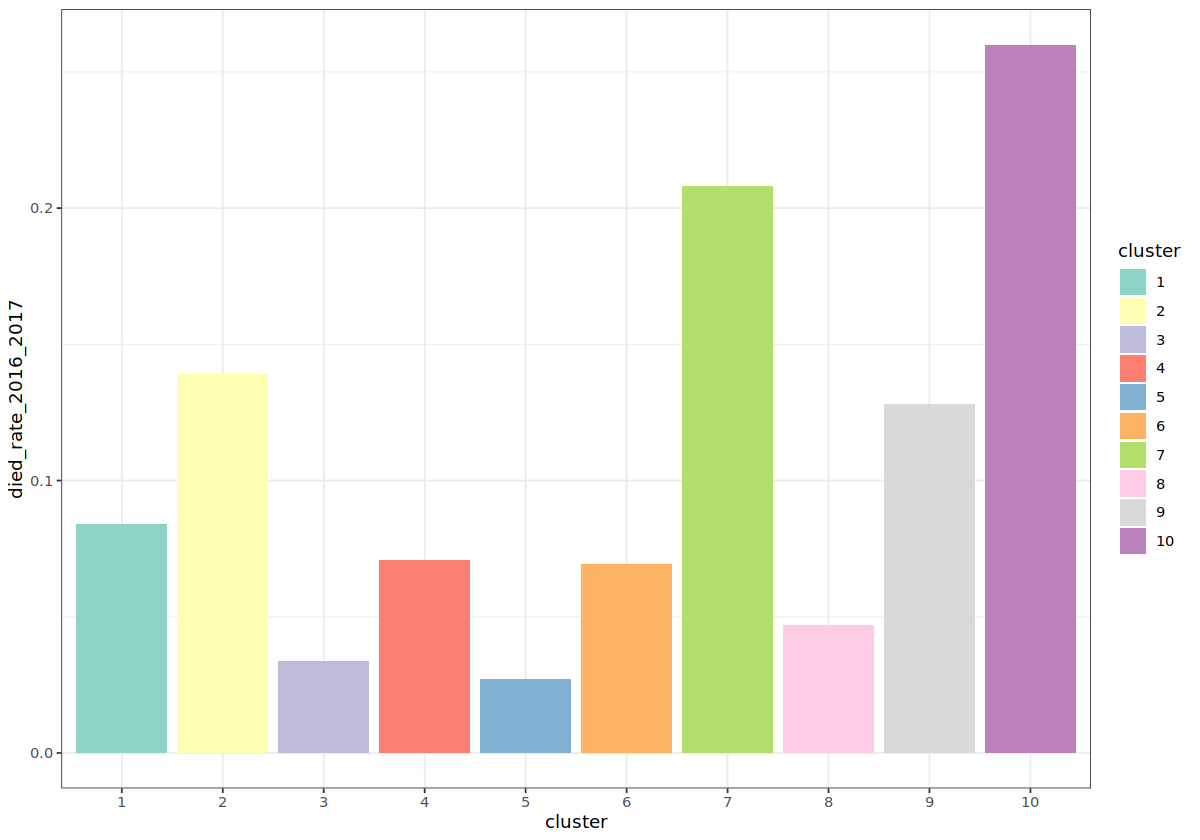

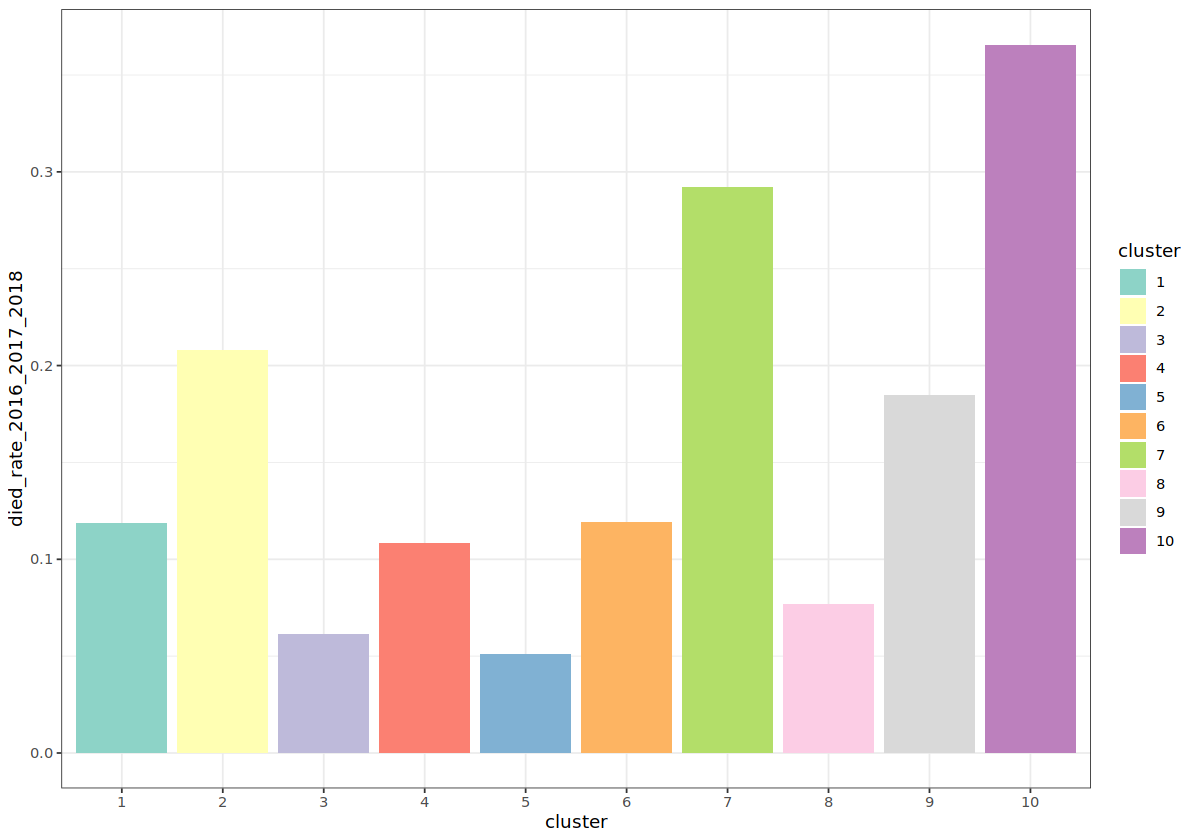

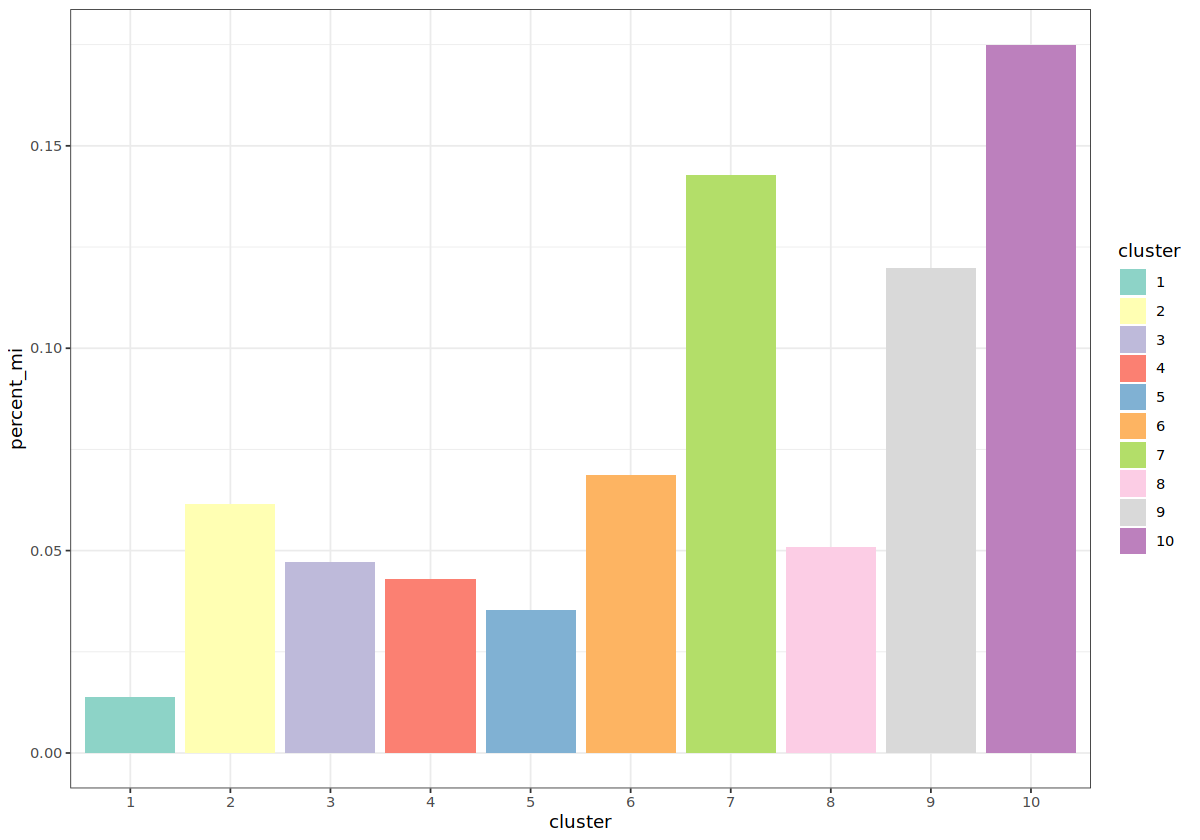

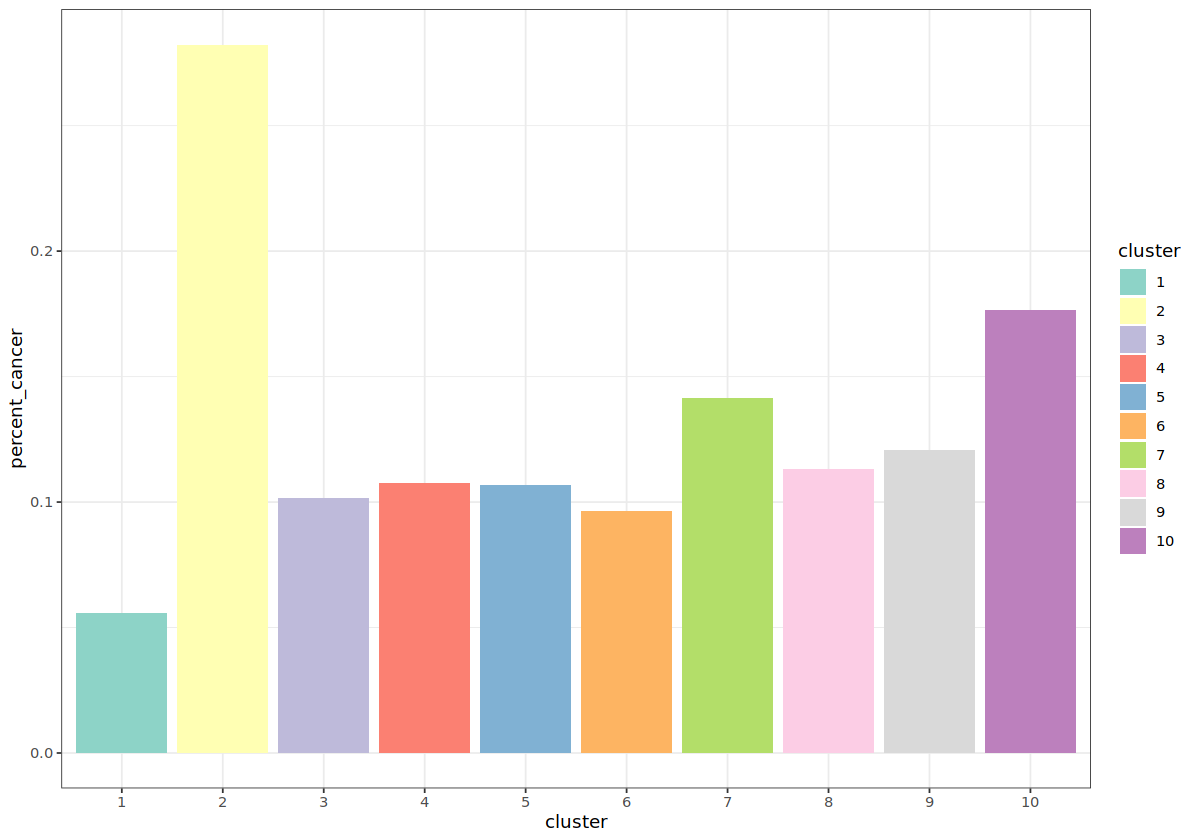

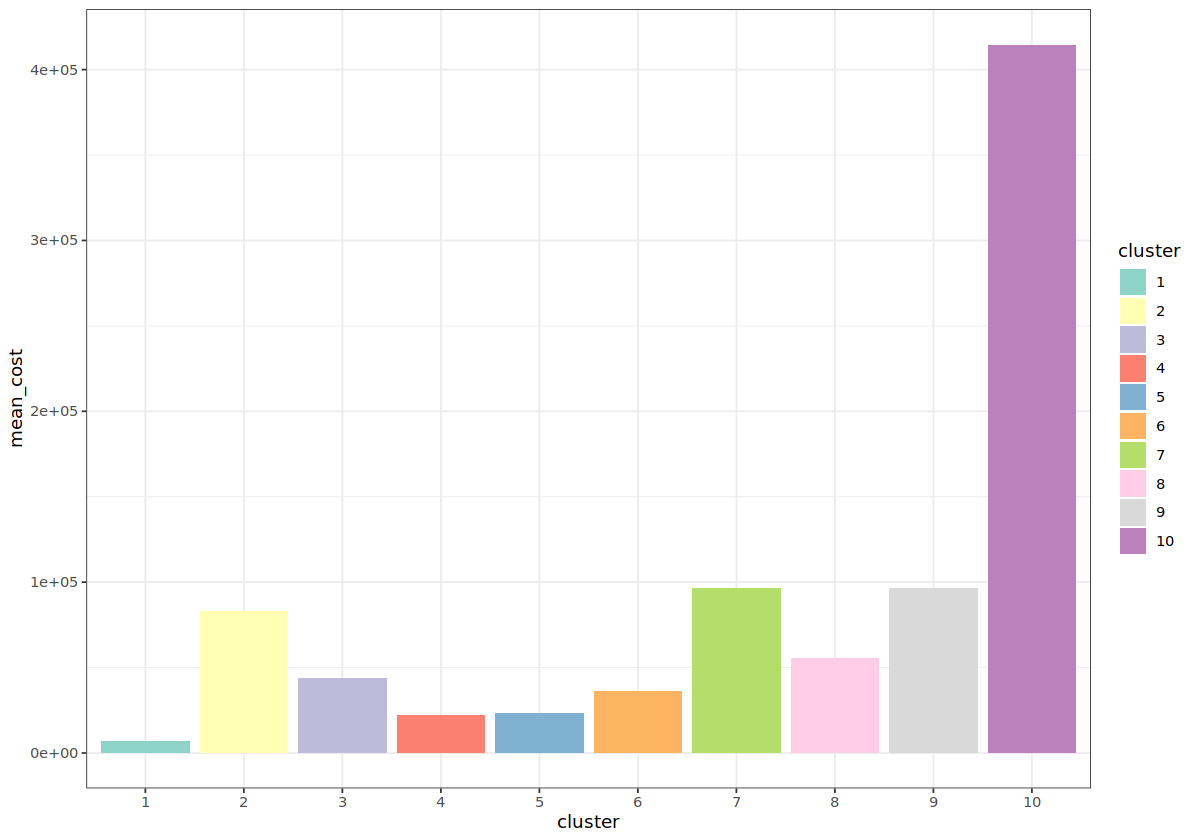

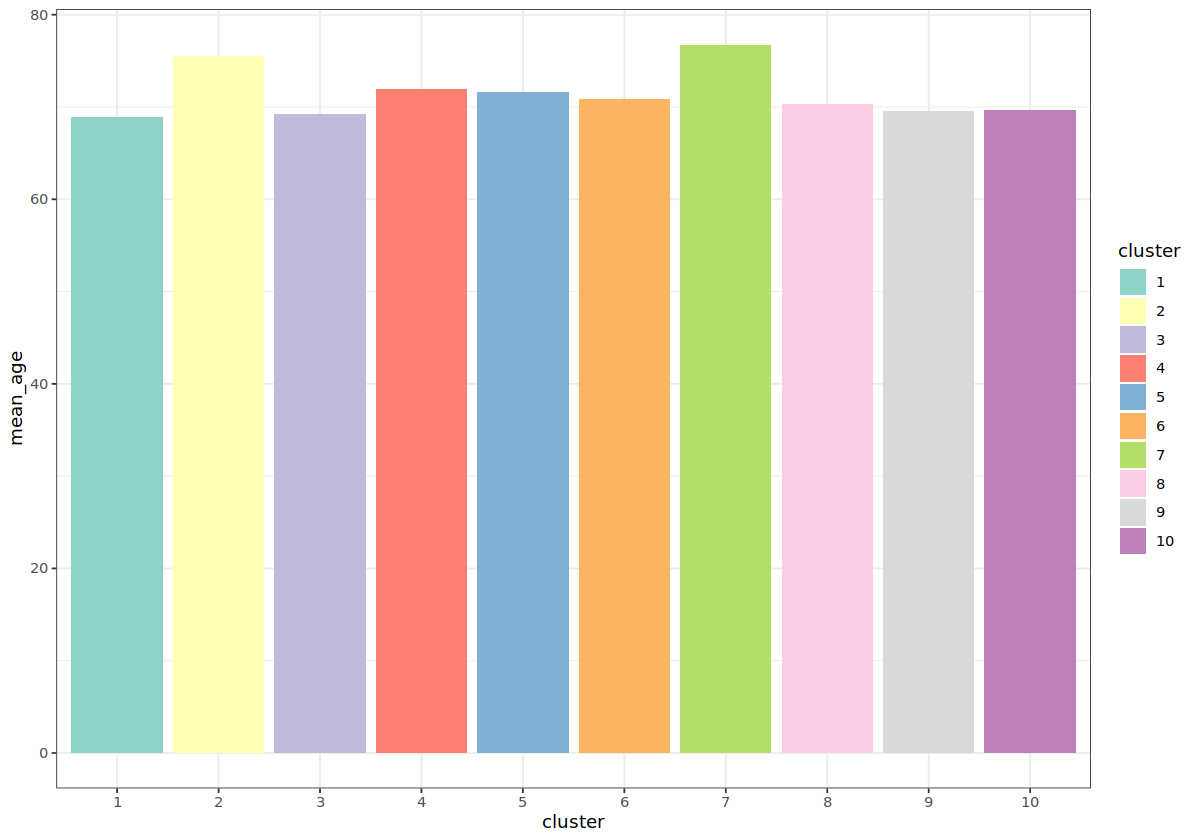

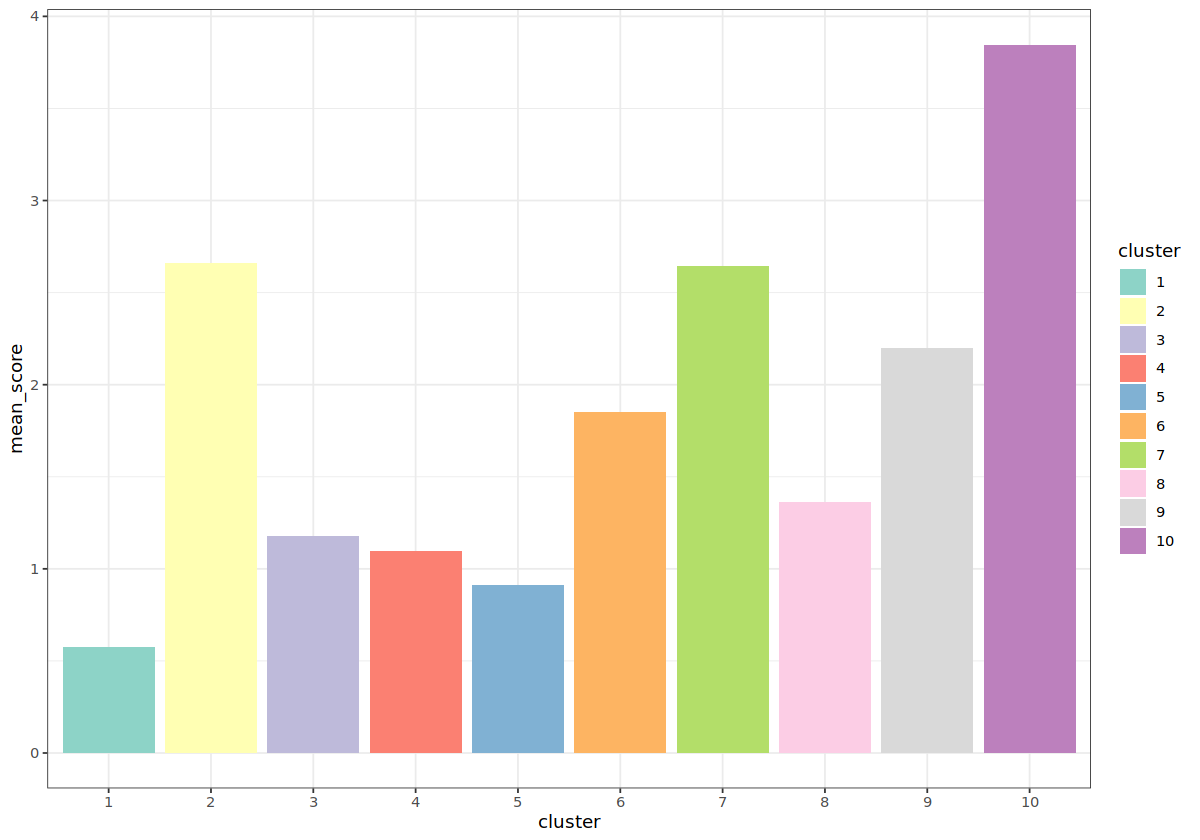

In [26]:
# create bar plots of prevalence of diseases by cluster
# we will use pastell colors

mother_plot <-
    ggplot(data = prevalences, aes(fill = cluster, x = cluster)) +
    scale_fill_brewer(palette = "Set3") +
    theme_bw() 

death_16_17_plot <-
    mother_plot +
    geom_bar(aes(y = died_rate_2016_2017), stat = "identity")

death_16_17_plot

death_16_17_18_19_20_plot <-
    mother_plot +
    geom_bar(aes(y = died_rate_2016_2017_2018), stat = "identity")

death_16_17_18_19_20_plot

mi_plot <-
    mother_plot +
    geom_bar(aes(y = percent_mi), stat = "identity")

mi_plot

cancer_plot <-
    mother_plot +
    geom_bar(aes(y = percent_cancer), stat = "identity")

cancer_plot

# mean cost plot
mean_cost_plot <-
    mother_plot +
    geom_bar(aes(y = mean_cost), stat = "identity")

mean_cost_plot

# mean age plot
mean_age_plot <-
    mother_plot +
    geom_bar(aes(y = mean_age), stat = "identity")

mean_age_plot

# mean score plot
mean_score_plot <-
    mother_plot +
    geom_bar(aes(y = mean_score), stat = "identity")

mean_score_plot

## Find costs of each physician per patient

In [27]:
# find mean cost per physician
physician_cost <- full_data[, .(
    sum_cost = sum(cost),
    n = length(unique(id))
), by = c("provider", "provider_specialty", "cluster")]
head(physician_cost)

provider,provider_specialty,cluster,sum_cost,n
<chr>,<chr>,<dbl>,<dbl>,<int>
1265609275,18,2,41364.51,4
1730170630,06,2,39279.86,2
1811988454,06,2,318.89,1
1962492033,30,2,732.87,10
1043294770,93,2,546.03,3
1770514119,11,2,1560.83,2


In [28]:
physician_cost[, mean_cost := sum_cost / n]
head(physician_cost)

provider,provider_specialty,cluster,sum_cost,n,mean_cost
<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
1265609275,18,2,41364.51,4,10341.128
1730170630,06,2,39279.86,2,19639.930
1811988454,06,2,318.89,1,318.890
1962492033,30,2,732.87,10,73.287
1043294770,93,2,546.03,3,182.010
1770514119,11,2,1560.83,2,780.415


In [29]:
# find the percentile of the mean cost of each physician in each cluster
#physician_cost[, percentile := pnorm(mean_cost, mean = mean(mean_cost), sd = sd(mean_cost)),
#    by = c("cluster", "provider_specialty")
#]
physician_cost[, percentile := rank(mean_cost) / .N, by = c("cluster", "provider_specialty")]
# add decile
physician_cost[, decile := cut(percentile, breaks = seq(0, 1, 0.1), include.lowest = T)]
# add quartile
physician_cost[, quintile := cut(percentile, breaks = seq(0, 1, 0.20), include.lowest = T)]
head(physician_cost)

provider,provider_specialty,cluster,sum_cost,n,mean_cost,percentile,decile,quintile
<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>
1265609275,18,2,41364.51,4,10341.128,0.9491728,"(0.9,1]","(0.8,1]"
1730170630,06,2,39279.86,2,19639.930,0.9763367,"(0.9,1]","(0.8,1]"
1811988454,06,2,318.89,1,318.890,0.5393060,"(0.5,0.6]","(0.4,0.6]"
1962492033,30,2,732.87,10,73.287,0.4612018,"(0.4,0.5]","(0.4,0.6]"
1043294770,93,2,546.03,3,182.010,0.2747400,"(0.2,0.3]","(0.2,0.4]"
1770514119,11,2,1560.83,2,780.415,0.6182602,"(0.6,0.7]","(0.6,0.8]"


In [30]:
# create a  dataset with unique id and other things
modelling_data <- unique(full_data[, -("cost")])
# merge with physician cost
modelling_data <- modelling_data[physician_cost, on = c("provider", "provider_specialty", "cluster")]

In [31]:
# add score group
modelling_data[, score_group := case_when(
    score <=2 ~ "mild",
    2 < score & score < 5 ~ "moderate",
    score >= 5 ~ "severe")]

In [32]:
# add percent severe and percent moderate in each cluster
modelling_data[, percent_severe := sum(score_group == "severe") / .N, by = c("cluster")]
modelling_data[, percent_moderate := sum(score_group == "moderate") / .N, by = c("cluster")]

#group cluster based on percent severe
modelling_data[, cluster_severity_group := case_when(
    percent_severe <= 0.2 ~ "low_severe",
    0.2 < percent_severe & percent_severe < 0.4 ~ "moderate_severe",
    percent_severe >= 0.4 ~ "high_severe")]

In [33]:
# add cluster score mean and cluster age mean
modelling_data[, cluster_score_mean := mean(score), by = c("cluster")]
modelling_data[, cluster_age_mean := mean(age), by = c("cluster")]

# add cluster centered age and score
modelling_data[, cluster_centered_score := score - cluster_score_mean]
modelling_data[, cluster_centered_age := age - cluster_age_mean]

In [34]:
modelling_data[, cluster := as.factor(cluster)]

In [35]:
head(modelling_data)

id,year,provider,provider_specialty,i.id,i.year,mi,chf,pvd,cevd,dementia,cpd,rheumd,pud,mld,diab,diabwc,hp,rend,canc,msld,metacanc,aids,score,state,county,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020,cluster,i.id.1,i.year.1,sum_cost,n,mean_cost,percentile,decile,quintile,score_group,percent_severe,percent_moderate,cluster_severity_group,cluster_score_mean,cluster_age_mean,cluster_centered_score,cluster_centered_age
<int>,<dbl>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,1265609275,18,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,41364.51,4,10341.13,0.9491728,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.5090975,3.848933
192624775,2016,1265609275,18,192624775,2016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,22,160,1,1,83,FALSE,FALSE,FALSE,FALSE,FALSE,2,192624775,2016,41364.51,4,10341.13,0.9491728,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.5090975,7.848933
194457811,2016,1265609275,18,194457811,2016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,160,2,1,83,FALSE,FALSE,FALSE,FALSE,FALSE,2,194457811,2016,41364.51,4,10341.13,0.9491728,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-3.5090975,7.848933
466201991,2016,1265609275,18,466201991,2016,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,22,040,2,1,66,FALSE,FALSE,FALSE,FALSE,FALSE,2,466201991,2016,41364.51,4,10341.13,0.9491728,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-1.5090975,-9.151067
100000015,2016,1730170630,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,39279.86,2,19639.93,0.9763367,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.5090975,3.848933
464671219,2016,1730170630,06,464671219,2016,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,4,22,160,2,1,57,FALSE,FALSE,FALSE,FALSE,FALSE,2,464671219,2016,39279.86,2,19639.93,0.9763367,"(0.9,1]","(0.8,1]",moderate,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,0.4909025,-18.151067


In [36]:
#save the data
write.fst(modelling_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/modelling_data.fst")

# Descriptives

In [37]:
# death in 2016 to 2017 (uear after the data) divided by cluster and physician for cardiologists
modelling_data[provider_specialty == "06" & n > 10
    , .(
    n = .N,
    died = sum(died_2016, na.rm=T) +sum(died_2017, na.rm=T),
    died_rate = round((sum(died_2016, na.rm = T) + sum(died_2017, na.rm = T)) / .N, 3),
    mean_spending = round(mean(mean_cost), 3),
    pct_mi =  round(mean(mi), 3)
), keyby = c("cluster_severity_group", "quintile")]

# death in 2017 to 2018 (uear after the data) divided by cluster and physician for primary care physicians
modelling_data[provider_specialty %in% c("01", "08", "11", "38") & n > 10,
    .(
        n = .N,
        died = sum(died_2017, na.rm = T) + sum(died_2018, na.rm = T),
        died_rate = round((sum(died_2017, na.rm = T) + sum(died_2018, na.rm = T)) / .N, 3),
        mean_spending = round(mean(mean_cost), 3),
        pct_mi = round(mean(mi), 3)
    ),
    keyby = c("cluster_severity_group", "quintile")
]



cluster_severity_group,quintile,n,died,died_rate,mean_spending,pct_mi
<chr>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
high_severe,"[0,0.2]",5448,2070,0.380,40.795,0.323
high_severe,"(0.2,0.4]",5183,2031,0.392,123.067,0.349
high_severe,"(0.4,0.6]",4205,1688,0.401,263.126,0.341
high_severe,"(0.6,0.8]",3073,1122,0.365,665.260,0.334
high_severe,"(0.8,1]",2928,1012,0.346,4497.096,0.320
low_severe,"[0,0.2]",54403,8339,0.153,86.763,0.135
low_severe,"(0.2,0.4]",73718,9144,0.124,250.482,0.117
low_severe,"(0.4,0.6]",78268,8872,0.113,517.360,0.113
low_severe,"(0.6,0.8]",81137,8889,0.110,1252.334,0.116


cluster_severity_group,quintile,n,died,died_rate,mean_spending,pct_mi
<chr>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
high_severe,"[0,0.2]",1525,439,0.288,72.508,0.283
high_severe,"(0.2,0.4]",561,182,0.324,255.141,0.344
high_severe,"(0.4,0.6]",953,274,0.288,491.082,0.269
high_severe,"(0.6,0.8]",1714,474,0.277,1863.464,0.260
high_severe,"(0.8,1]",9996,2593,0.259,203191.693,0.217
low_severe,"[0,0.2]",49063,3925,0.080,114.791,0.055
low_severe,"(0.2,0.4]",68416,5466,0.080,281.953,0.039
low_severe,"(0.4,0.6]",101930,8380,0.082,557.263,0.035
low_severe,"(0.6,0.8]",125589,10460,0.083,1145.003,0.036


# Modeling

In [64]:
modelling_data <- read.fst("/work/postresearch/Shared/Projects/Farbod/Clustering/modelling_data.fst",
    as.data.table = TRUE
)

In [65]:
head(modelling_data)

id,year,provider,provider_specialty,i.id,i.year,mi,chf,pvd,cevd,dementia,cpd,rheumd,pud,mld,diab,diabwc,hp,rend,canc,msld,metacanc,aids,score,state,county,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020,cluster,i.id.1,i.year.1,sum_cost,n,mean_cost,percentile,decile,quintile,score_group,percent_severe,percent_moderate,cluster_severity_group,cluster_score_mean,cluster_age_mean,cluster_centered_score,cluster_centered_age
<int>,<dbl>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,1265609275,18,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,41364.51,4,10341.13,0.9491728,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.5090975,3.848933
192624775,2016,1265609275,18,192624775,2016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,22,160,1,1,83,FALSE,FALSE,FALSE,FALSE,FALSE,2,192624775,2016,41364.51,4,10341.13,0.9491728,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.5090975,7.848933
194457811,2016,1265609275,18,194457811,2016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,160,2,1,83,FALSE,FALSE,FALSE,FALSE,FALSE,2,194457811,2016,41364.51,4,10341.13,0.9491728,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-3.5090975,7.848933
466201991,2016,1265609275,18,466201991,2016,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,22,040,2,1,66,FALSE,FALSE,FALSE,FALSE,FALSE,2,466201991,2016,41364.51,4,10341.13,0.9491728,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-1.5090975,-9.151067
100000015,2016,1730170630,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,39279.86,2,19639.93,0.9763367,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.5090975,3.848933
464671219,2016,1730170630,06,464671219,2016,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,4,22,160,2,1,57,FALSE,FALSE,FALSE,FALSE,FALSE,2,464671219,2016,39279.86,2,19639.93,0.9763367,"(0.9,1]","(0.8,1]",moderate,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,0.4909025,-18.151067


In [66]:
# divide ages by 10
modelling_data[, cluster_centered_age_10 := cluster_centered_age / 10]
modelling_data[, cluster_age_mean_10 := cluster_age_mean / 10]


In [67]:
modelling_data[, died_2016_2017 := died_2016 + died_2017]

In [13]:
# run the multilevel model (physicians nested in clsuters)
# these will be physicians nested in specialties nested in clusters
library(lme4)

model_death_next_year <- glmer(
    died_2016_2017 ~ 
    cluster_centered_age_10 +
    score_group + 
    cluster_age_mean_10 + 
    cluster_severity_group * 
    quintile + 
    (1|cluster),
    data = modelling_data[1:10000000,][provider_specialty=="06"& n>5],
    family = binomial(link = "logit"),
    control = glmerControl(optimizer = "Nelder_Mead")
)

In [12]:
summary(model_death_next_year)


Correlation matrix not shown by default, as p = 19 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace Approximation) ['glmerMod']
 Family: binomial  ( logit )
Formula: died_2016_2017 ~ cluster_centered_age_10 + score_group + cluster_age_mean_10 +      cluster_severity_group * quintile + (1 | cluster)
   Data: modelling_data[1:1e+06, ][provider_specialty == "06" & n > 5]
Control: glmerControl(optimizer = "Nelder_Mead")

     AIC      BIC   logLik deviance df.resid 
 13919.4  14075.6  -6939.7  13879.4    18230 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8905 -0.4184 -0.2580 -0.1637 15.6078 

Random effects:
 Groups  Name        Variance Std.Dev.
 cluster (Intercept) 0.3376   0.5811  
Number of obs: 18250, groups:  cluster, 10

Fixed effects:
                                                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)                                             -7.21651    5.61777  -1.285  0.19894    
cluster_centered_age_10                                  0.47573    0.0

In [102]:
t(exp(coef(model_death_next_year)$cluster)[1, ])

,1
(Intercept),0.002394393
cluster_centered_age_10,1.341273141
cluster_centered_score,1.193862057
cluster_age_mean_10,1.454064646
cluster_score_mean,1.455489171
"quartile(0.25,0.5]",0.955935172
"quartile(0.5,0.75]",0.950162763
"quartile(0.75,1]",0.873890717
"cluster_score_mean:quartile(0.25,0.5]",1.014841910
"cluster_score_mean:quartile(0.5,0.75]",1.005964394


## based on physician attribution

In [15]:
modelling_data[id == "100000015"]

id,year,provider,provider_specialty,i.id,i.year,mi,chf,pvd,cevd,dementia,cpd,rheumd,pud,mld,diab,diabwc,hp,rend,canc,msld,metacanc,aids,score,state,county,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020,cluster,i.id.1,i.year.1,sum_cost,n,mean_cost,percentile,decile,quintile,score_group,percent_severe,percent_moderate,cluster_severity_group,cluster_score_mean,cluster_age_mean,cluster_centered_score,cluster_centered_age,cluster_centered_age_10,cluster_age_mean_10,died_2016_2017
<int>,<dbl>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
100000015,2016,1265609275,18,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,41364.51,4,10341.128,0.94917275,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0
100000015,2016,1730170630,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,39279.86,2,19639.930,0.97633675,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0
100000015,2016,1811988454,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,318.89,1,318.890,0.53930603,"(0.5,0.6]","(0.4,0.6]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0
100000015,2016,1962492033,30,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,732.87,10,73.287,0.46120182,"(0.4,0.5]","(0.4,0.6]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0
100000015,2016,1043294770,93,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,546.03,3,182.010,0.27473999,"(0.2,0.3]","(0.2,0.4]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0
100000015,2016,1770514119,11,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,1560.83,2,780.415,0.61826024,"(0.6,0.7]","(0.6,0.8]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0
100000015,2016,1003898461,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,605.19,10,60.519,0.15403868,"(0.1,0.2]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0
100000015,2016,1174560288,29,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,113.64,1,113.640,0.15687839,"(0.1,0.2]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0
100000015,2016,1265769392,11,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,537.23,1,537.230,0.53756290,"(0.5,0.6]","(0.4,0.6]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0


In [35]:
# find which physician provided the majority of each patient's care (the physician with the most number of rows for patient)
# find the number of rows for each patient
patient_rows <- full_data[, .(n = .N), by = c("id", "provider","provider_specialty")]

head(patient_rows)

id,provider,provider_specialty,n
<int>,<chr>,<chr>,<int>
100000015,1265609275,18,26
100000015,1730170630,06,13
100000015,1811988454,06,2
100000015,1962492033,30,1
100000015,1043294770,93,1
100000015,1770514119,11,4


In [39]:
# find top physician for each patient per specialty
top_physician <- patient_rows[, max_n_specialty := max(n), by = c("id", "provider_specialty")]
top_physician <- top_physician[n == max_n_specialty]
head(top_physician)

id,provider,provider_specialty,n,max_n_specialty
<int>,<chr>,<chr>,<int>,<int>
100000015,1265609275,18,26,26
100000015,1730170630,06,13,13
100000015,1962492033,30,1,1
100000015,1043294770,93,1,1
100000015,1174560288,29,1,1
100000015,1174560288,11,7,7


In [68]:
# add to modelling data, using a column that is 1 if the physician is the top physician for the patient (do a left join)
modelling_data <- merge(modelling_data, top_physician[, .(id, provider, max_n_specialty)],
    by = c("id", "provider"), all.x = T
)

# add a column that is 1 if the physician is the top physician for the patient
modelling_data[, top_physician := ifelse(is.na(max_n_specialty), 0, 1)]

head(modelling_data)


id,provider,year,provider_specialty,i.id,i.year,mi,chf,pvd,cevd,dementia,cpd,rheumd,pud,mld,diab,diabwc,hp,rend,canc,msld,metacanc,aids,score,state,county,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020,cluster,i.id.1,i.year.1,sum_cost,n,mean_cost,percentile,decile,quintile,score_group,percent_severe,percent_moderate,cluster_severity_group,cluster_score_mean,cluster_age_mean,cluster_centered_score,cluster_centered_age,cluster_centered_age_10,cluster_age_mean_10,died_2016_2017,max_n_specialty,top_physician
<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
100000015,1003898461,2016,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,605.19,10,60.519,0.1540387,"(0.1,0.2]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,NA,0
100000015,1043294770,2016,93,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,546.03,3,182.010,0.2747400,"(0.2,0.3]","(0.2,0.4]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,1,1
100000015,1174560288,2016,29,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,113.64,1,113.640,0.1568784,"(0.1,0.2]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,1,1
100000015,1174560288,2016,29,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,113.64,1,113.640,0.1568784,"(0.1,0.2]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,7,1
100000015,1174560288,2016,11,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,3384.04,1,3384.040,0.8237697,"(0.8,0.9]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,1,1
100000015,1174560288,2016,11,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,3384.04,1,3384.040,0.8237697,"(0.8,0.9]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,7,1


In [72]:
modelling_data[id=="100000015"]


id,provider,year,provider_specialty,i.id,i.year,mi,chf,pvd,cevd,dementia,cpd,rheumd,pud,mld,diab,diabwc,hp,rend,canc,msld,metacanc,aids,score,state,county,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020,cluster,i.id.1,i.year.1,sum_cost,n,mean_cost,percentile,decile,quintile,score_group,percent_severe,percent_moderate,cluster_severity_group,cluster_score_mean,cluster_age_mean,cluster_centered_score,cluster_centered_age,cluster_centered_age_10,cluster_age_mean_10,died_2016_2017,max_n_specialty,top_physician,quartile
<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<fct>
100000015,1003898461,2016,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,605.19,10,60.519,0.15403868,"(0.1,0.2]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,NA,0,1
100000015,1043294770,2016,93,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,546.03,3,182.010,0.27473999,"(0.2,0.3]","(0.2,0.4]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,1,1,2
100000015,1174560288,2016,29,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,113.64,1,113.640,0.15687839,"(0.1,0.2]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,1,1,1
100000015,1174560288,2016,29,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,113.64,1,113.640,0.15687839,"(0.1,0.2]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,7,1,1
100000015,1174560288,2016,11,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,3384.04,1,3384.040,0.82376969,"(0.8,0.9]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,1,1,4
100000015,1174560288,2016,11,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,3384.04,1,3384.040,0.82376969,"(0.8,0.9]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,7,1,4
100000015,1245451814,2016,99,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,502.80,6,83.800,0.05454796,"[0,0.1]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,1,1,1
100000015,1265609275,2016,18,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,41364.51,4,10341.128,0.94917275,"(0.9,1]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,26,1,4
100000015,1265769392,2016,11,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,537.23,1,537.230,0.53756290,"(0.5,0.6]","(0.4,0.6]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,NA,0,3


In [71]:
modelling_data[, quartile := cut(percentile, breaks = 4, labels = c("1", "2", "3", "4"))]

In [70]:
#save modelling data again
write.fst(modelling_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/modelling_data.fst")

In [2]:
modelling_data <- read.fst("/work/postresearch/Shared/Projects/Farbod/Clustering/modelling_data.fst",
    as.data.table = TRUE
)

In [17]:
# use bayesian mixed effects (brms)
library(brms)

model_death_next_year <- brm(
    died_2016_2017 ~
        cluster_centered_age_10 +
        score_group +
        cluster_age_mean_10 +
        cluster_severity_group * quintile +
        (1 | cluster),
    data = modelling_data[died_2016_2017 %in% c(0, 1)][provider_specialty == "06" & top_physician == 1],
    family = "bernoulli",
    cores = numcores,
    iter = 2000,
    warmup = 1000,
    chains = 2,
    opencl = opencl(c(0, 0))
)

ERROR: Error: CmdStan path has not been set yet. See ?set_cmdstan_path.


In [10]:
prior_summary(model_death_next_year)

ERROR: Error in prior_summary(model_death_next_year): object 'model_death_next_year' not found


In [17]:
summary(model_death_next_year)

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”


 Family: bernoulli 
  Links: mu = logit 
Formula: died_2016_2017 ~ cluster_centered_age_10 + score_group + cluster_age_mean_10 + cluster_severity_group * quintile + (1 | cluster) 
   Data: modelling_data[1:10000][provider_specialty == "06" (Number of observations: 363) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Group-Level Effects: 
~cluster (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.60      0.98     0.53     4.64 1.12       48       27

Population-Level Effects: 
                                                     Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept                                             -367.24    325.82  -898.67    31.54 2.08        5       19
cluster_centered_age_10                                  0.68      0.48    -0.26     1.66 1.05       74      102
score_groupmoderate                                 

In [5]:
modelling_data <- read_fst("modelling_data.fst", as.data.table = TRUE)

In [6]:
head(modelling_data)

id,provider,year,provider_specialty,i.id,i.year,mi,chf,pvd,cevd,dementia,cpd,rheumd,pud,mld,diab,diabwc,hp,rend,canc,msld,metacanc,aids,score,state,county,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020,cluster,i.id.1,i.year.1,sum_cost,n,mean_cost,percentile,decile,quintile,score_group,percent_severe,percent_moderate,cluster_severity_group,cluster_score_mean,cluster_age_mean,cluster_centered_score,cluster_centered_age,cluster_centered_age_10,cluster_age_mean_10,died_2016_2017,max_n_specialty,top_physician
<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
100000015,1003898461,2016,06,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,605.19,10,60.519,0.1540387,"(0.1,0.2]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,NA,0
100000015,1043294770,2016,93,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,546.03,3,182.010,0.2747400,"(0.2,0.3]","(0.2,0.4]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,1,1
100000015,1174560288,2016,29,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,113.64,1,113.640,0.1568784,"(0.1,0.2]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,1,1
100000015,1174560288,2016,29,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,113.64,1,113.640,0.1568784,"(0.1,0.2]","[0,0.2]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,7,1
100000015,1174560288,2016,11,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,3384.04,1,3384.040,0.8237697,"(0.8,0.9]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,1,1
100000015,1174560288,2016,11,100000015,2016,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,22,160,1,1,79,FALSE,FALSE,FALSE,FALSE,FALSE,2,100000015,2016,3384.04,1,3384.040,0.8237697,"(0.8,0.9]","(0.8,1]",mild,0.3261333,0.1904615,moderate_severe,3.509098,75.15107,-2.509098,3.848933,0.3848933,7.515107,0,7,1


In [11]:
# run the multilevel model (physicians nested in clsuters) only for main cardiologists
# these will be physicians nested in specialties nested in clusters
library(lme4)

model_death_next_year_cardio <- glmer(
    died_2016_2017 ~ 
    cluster_centered_age_10 +
    score_group + 
    cluster_age_mean_10 + 
    cluster_severity_group * 
    quintile + 
    (1|cluster),
    data = modelling_data[provider_specialty=="06" & top_physician==1],
    family = binomial(link = "logit"),
    control = glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)
)

In [ ]:
summary(model_death_next_year_cardio)


Correlation matrix not shown by default, as p = 19 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace Approximation) ['glmerMod']
 Family: binomial  ( logit )
Formula: died_2016_2017 ~ cluster_centered_age_10 + score_group + cluster_age_mean_10 +      cluster_severity_group * quintile + (1 | cluster)
   Data: modelling_data[provider_specialty == "06" & top_physician ==      1][1:1000]
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
   563.4    661.6   -261.7    523.4      980 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3460 -0.2854 -0.2046 -0.1524 10.0023 

Random effects:
 Groups  Name        Variance Std.Dev.
 cluster (Intercept) 0.3485   0.5904  
Number of obs: 1000, groups:  cluster, 10

Fixed effects:
                                                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)                                              -17.76274 2609.81261  -0.007  0.99457    
cluster_centered_age_10              

In [ ]:
# run the multilevel model (physicians nested in clsuters) only for main cardiologists
# these will be physicians nested in specialties nested in clusters
library(lme4)

model_death_next_year_pcp <- glmer(
    died_2016_2017 ~
        cluster_centered_age_10 +
        score_group +
        cluster_age_mean_10 +
        cluster_severity_group *
            quintile +
        (1 | cluster),
    data = modelling_data[provider_specialty %in% c("01", "08", "11", "38") & top_physician == 1],
    family = binomial(link = "logit"),
    control = glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)
)

In [ ]:
summary(model_death_next_year_pcp)